# Exploration des données - feature engineering
Created by: Thomas Durand-Texte, Feb. 2023

# Import des packages et données
## import des packages

In [1]:
import os

import pandas as pd
from pandas import IndexSlice as idx

import pickle

import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import datetime as dt
import scipy.stats as st

import missingno as msno

import pingouin as pg
from sklearn import linear_model
from sklearn import model_selection, metrics, preprocessing


import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [2]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    base_palette = sns.color_palette()
    sns.set_theme( 'notebook' , rc=rc )
    sns.set_palette( base_palette )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [3]:
def print_listdir( path=None, level=0, exclude=['ressources']) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0 (copy).ipynb
 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 install_packages_venv.sh


1. Chargement des données
2. lower strings
3. compression et sauvegarde des données

In [4]:
path = 'data/source/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

if True:
    df = pd.read_csv( path + filename + '.csv' )
    for key in df.keys():
        if df[key].dtype == 'object':
            df[key] = df[key].str.lower()

    # suppression des colonnes vides (ici seulement comments)
    df.drop( columns=df.keys()[df.isna().sum(0) == len(df)], inplace=True )

    df.to_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
else:
    df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

del compression

In [5]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHG

# 1. Nettoyage

## 1.1 Initial Filtering : contexte = usage non résidentiel

value counts des 'BuildingType'

In [6]:
display( df['BuildingType'].value_counts() )

nonresidential          1460
multifamily lr (1-4)    1018
multifamily mr (5-9)     580
multifamily hr (10+)     110
sps-district k-12         98
nonresidential cos        85
campus                    24
nonresidential wa          1
Name: BuildingType, dtype: int64

Suppression des Mutlifamily

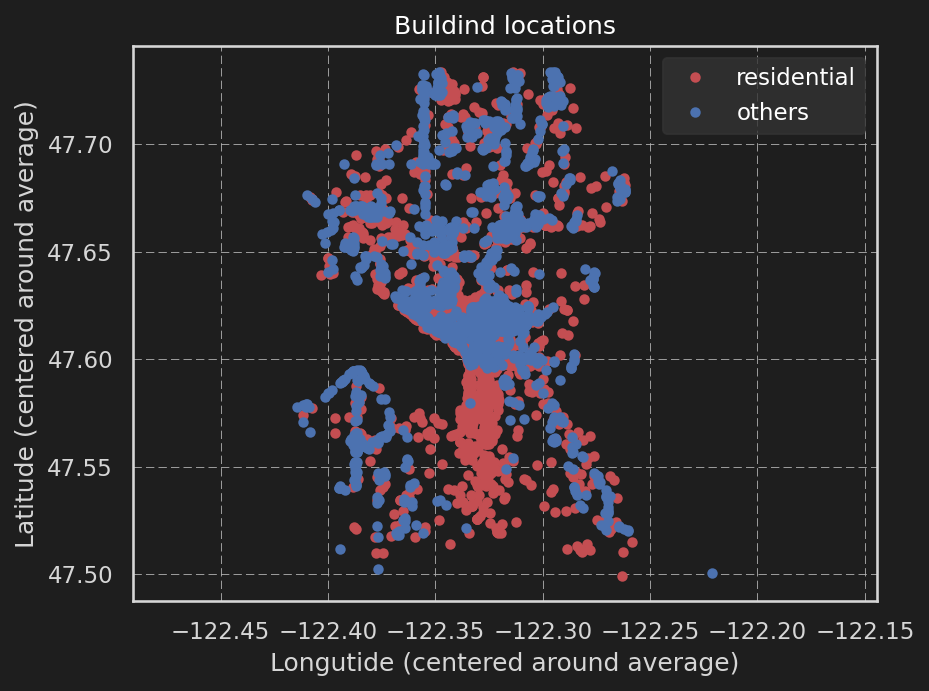

In [7]:
sr_loc = df['BuildingType'].str.contains('multifamily')


fig, ax = plt.subplots()
ax.plot( df.loc[~sr_loc,'Longitude'], df.loc[~sr_loc,'Latitude'], 'ro', markersize=4, label='residential')
ax.plot( df.loc[sr_loc,'Longitude'], df.loc[sr_loc,'Latitude'], 'bo', markersize=4, label='others')
ax.legend()
ax.axis('equal')
ax.set_title('Buildind locations')
ax.set_xlabel('Longutide (centered around average)')
ax.set_ylabel('Latitude (centered around average)')


sr_loc = sr_loc[sr_loc]
df.drop( index=sr_loc.index, inplace=True )

In [8]:
display( df['BuildingType'].value_counts() )

nonresidential        1460
sps-district k-12       98
nonresidential cos      85
campus                  24
nonresidential wa        1
Name: BuildingType, dtype: int64

Définition d'une fonction pour déterminer les éléments correspondant à du `housing`

In [9]:
def is_housing( sr ):
    sr_loc = (sr.str.contains('hous|multifamily', na=False)) \
        & (~sr.str.contains('warehouse|courthouse', na=True))
    return sr_loc

Vérification et suppression à partir du `PrimaryPropertyType`

In [10]:
var = 'PrimaryPropertyType'
sr_loc = is_housing(df[var])
display( df.loc[sr_loc, var].value_counts() )
df.drop( index=sr_loc[sr_loc].index, inplace=True )

low-rise multifamily    3
Name: PrimaryPropertyType, dtype: int64

1. Vérification et suppression pour le `LargestPropertyUseType`
2. Vérification des LargestPropertyUseType

In [11]:
vars = ['LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']


sr_loc = is_housing( df[vars[0]] )
df.drop( index=sr_loc[sr_loc].index, inplace=True )

sr_loc = is_housing( df[vars[1]] )
for var in vars[2:]:
    sr_loc = sr_loc | is_housing( df[var] )

# display( df['LargestPropertyUseType'].value_counts() )
# display( df['SecondLargestPropertyUseType'].value_counts() )
# display( df['ThirdLargestPropertyUseType'].value_counts() )

display( f'housing find in {sr_loc.sum()} elements' )
display( df.loc[sr_loc, vars] )

del vars, var

'housing find in 24 elements'

LargestPropertyUseType SecondLargestPropertyUseType  \
289                            retail store       other - restaurant/bar   
440                            retail store                      parking   
466                                  office   non-refrigerated warehouse   
488                                 parking          multifamily housing   
511                                  office          multifamily housing   
541              non-refrigerated warehouse          multifamily housing   
612                                  office                      parking   
912                            retail store          multifamily housing   
922   other - entertainment/public assembly          multifamily housing   
1167                                 office          multifamily housing   
1315                                 office          multifamily housing   
1328                                  hotel                      parking   
1599                             strip mall                       office   
1773                                 office          multifamily housing   
2398                                 office                      parking   
2407               residence hall/dormitory          multifamily housing   
2506                                 office                      parking   
2530                                 office          multifamily housing   
2759                                 office                        other   
2791                                 office          multifamily housing   
3134                                parking    supermarket/grocery store   
3163                                 office          multifamily housing   
3199                                 office                      parking   
3312                                 office                      parking   

     ThirdLargestPropertyUseType  
289          multifamily housing  
440          multifamily housing  
466          multifamily housing  
488                        hotel  
511                      parking  
541                 retail store  
612          multifamily housing  
912                   restaurant  
922                          NaN  
1167                         NaN  
1315                  restaurant  
1328         multifamily housing  
1599         multifamily housing  
1773                 bank branch  
2398         multifamily housing  
2407            financial office  
2506         multifamily housing  
2530                     parking  
2759         multifamily housing  
2791                  restaurant  
3134         multifamily housing  
3163                     parking  
3199         multifamily housing  
3312         multifamily housing

## 1.2 Outlier et DefaultData

In [12]:
def value_counts( sr ):
    value_counts = sr.value_counts()
    return pd.DataFrame( {'count': value_counts.values, 
                        '%':value_counts.values*(100/len(sr)) },
                        index=value_counts.index)

print('Outlier:')
display( value_counts( df['Outlier'] ) )
print('DefaultData:')
display( value_counts( df['DefaultData'] ) )

Outlier:


count         %
low outlier      14  0.845411
high outlier      2  0.120773

DefaultData:


count         %
False   1568  94.68599
True      88   5.31401

In [13]:
df['Outlier'] = df['Outlier'].map( {'low outlier':-1, 'high outlier':1}).fillna(0).astype('int')

## 1.3 Vérifications doublons

In [14]:
print("Number of duplicated: {:}".format( df['OSEBuildingID'].duplicated().sum() ) )

Number of duplicated: 0


## 1.4 Variables "inutiles"

Vérification des variables inutiles: création d'une liste "à supprimer"

In [15]:
vars_to_delete = ['OSEBuildingID', 'PropertyName',
        'TaxParcelIdentificationNumber',
        'CouncilDistrictCode',
        'Address', 'ListOfAllPropertyUseTypes']
# df.drop( columns=vars, inplace=True )

In [16]:
vars_to_check = ['DataYear', 'City', 'State']

for var in vars_to_check:
    if not var in df.keys() :
        print( f'{var} not in DataFrame')
        continue
    sr = df[var].value_counts()
    display(sr)
    if len(sr) < 2:
        # df.drop( columns=var, inplace=True )
        vars_to_delete.append( var )
        print( f'{var} added to the drop list')

2016    1656
Name: DataYear, dtype: int64

DataYear added to the drop list


seattle    1656
Name: City, dtype: int64

City added to the drop list


wa    1656
Name: State, dtype: int64

State added to the drop list


## 1.5 Variable de localité

In [17]:
vars_to_delete += ['ZipCode', 'Longitude', 'Latitude']

mask = 'Neighborhood'
display( df[mask].value_counts() )

downtown                  357
greater duwamish          346
magnolia / queen anne     150
lake union                146
northeast                 127
east                      118
northwest                  86
ballard                    70
north                      67
central                    55
southeast                  46
delridge                   46
southwest                  41
delridge neighborhoods      1
Name: Neighborhood, dtype: int64

In [18]:
df.loc[ df[mask] == 'delridge neighborhoods', mask ] = 'delridge'
display( df[mask].value_counts() )

downtown                 357
greater duwamish         346
magnolia / queen anne    150
lake union               146
northeast                127
east                     118
northwest                 86
ballard                   70
north                     67
central                   55
delridge                  47
southeast                 46
southwest                 41
Name: Neighborhood, dtype: int64

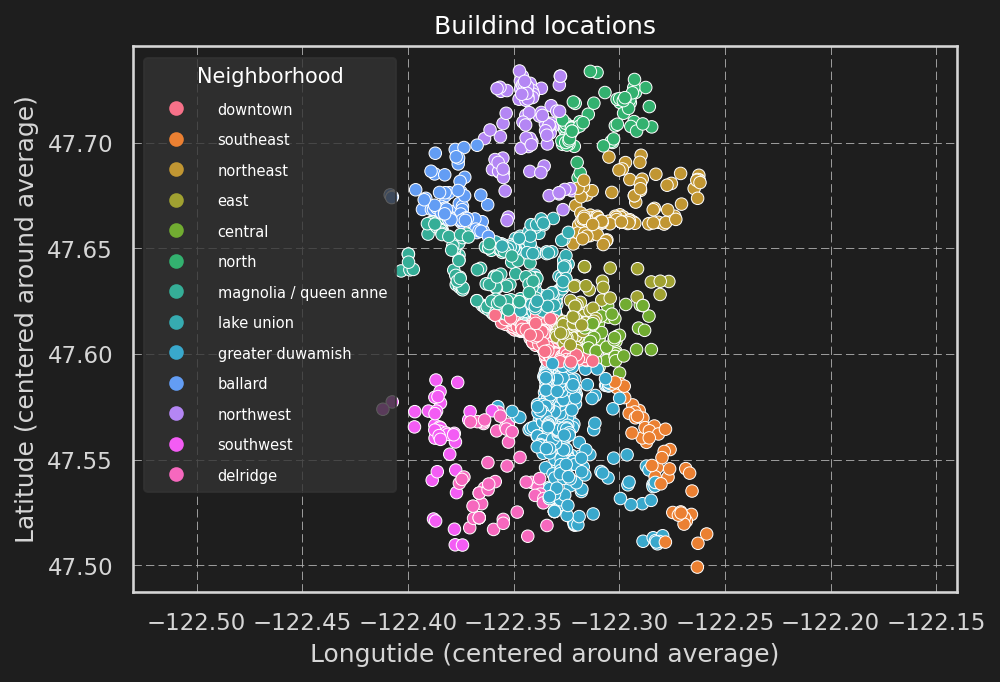

In [19]:
fig, ax = plt.subplots( figsize=(18*cm,12*cm))
scttr = sns.scatterplot( data=df, x='Longitude', y='Latitude', hue='Neighborhood', ax=ax )
ax.axis('equal')
ax.set_title('Buildind locations')
ax.set_xlabel('Longutide (centered around average)')
ax.set_ylabel('Latitude (centered around average)')

# for legend text
plt.setp(scttr.get_legend().get_texts(), fontsize='7') 
 
# for legend title
plt.setp(scttr.get_legend().get_title(), fontsize='10') 
plt.show()


## 1.5 Recherche et gestion des NaN
### 1.5.1 Détection des NaN
- Pour les Second & Third LargestPropertyUseType : uniquement 1 ou 2 utilisation du bâtiment
- Pour le YearsENERGYSTARCertified : pas de certification
- Pour le ENERGYSTARscore : essayer de le modéliser ?

In [20]:
sum_isna = df.isna().sum()
print( 'sum isna > 0:' )
display( sum_isna[sum_isna > 0])

sum isna > 0:


ZipCode                              16
NumberofBuildings                     2
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        812
SecondLargestPropertyUseTypeGFA     812
ThirdLargestPropertyUseType        1312
ThirdLargestPropertyUseTypeGFA     1312
YearsENERGYSTARCertified           1558
ENERGYSTARScore                     566
SiteEUI(kBtu/sf)                      3
SiteEUIWN(kBtu/sf)                    3
SourceEUI(kBtu/sf)                    2
SourceEUIWN(kBtu/sf)                  2
SiteEnergyUse(kBtu)                   2
SiteEnergyUseWN(kBtu)                 3
SteamUse(kBtu)                        2
Electricity(kWh)                      2
Electricity(kBtu)                     2
NaturalGas(therms)                    2
NaturalGas(kBtu)                      2
TotalGHGEmissions                     2
GHGEmissionsIntensity                 2
dtype: int64

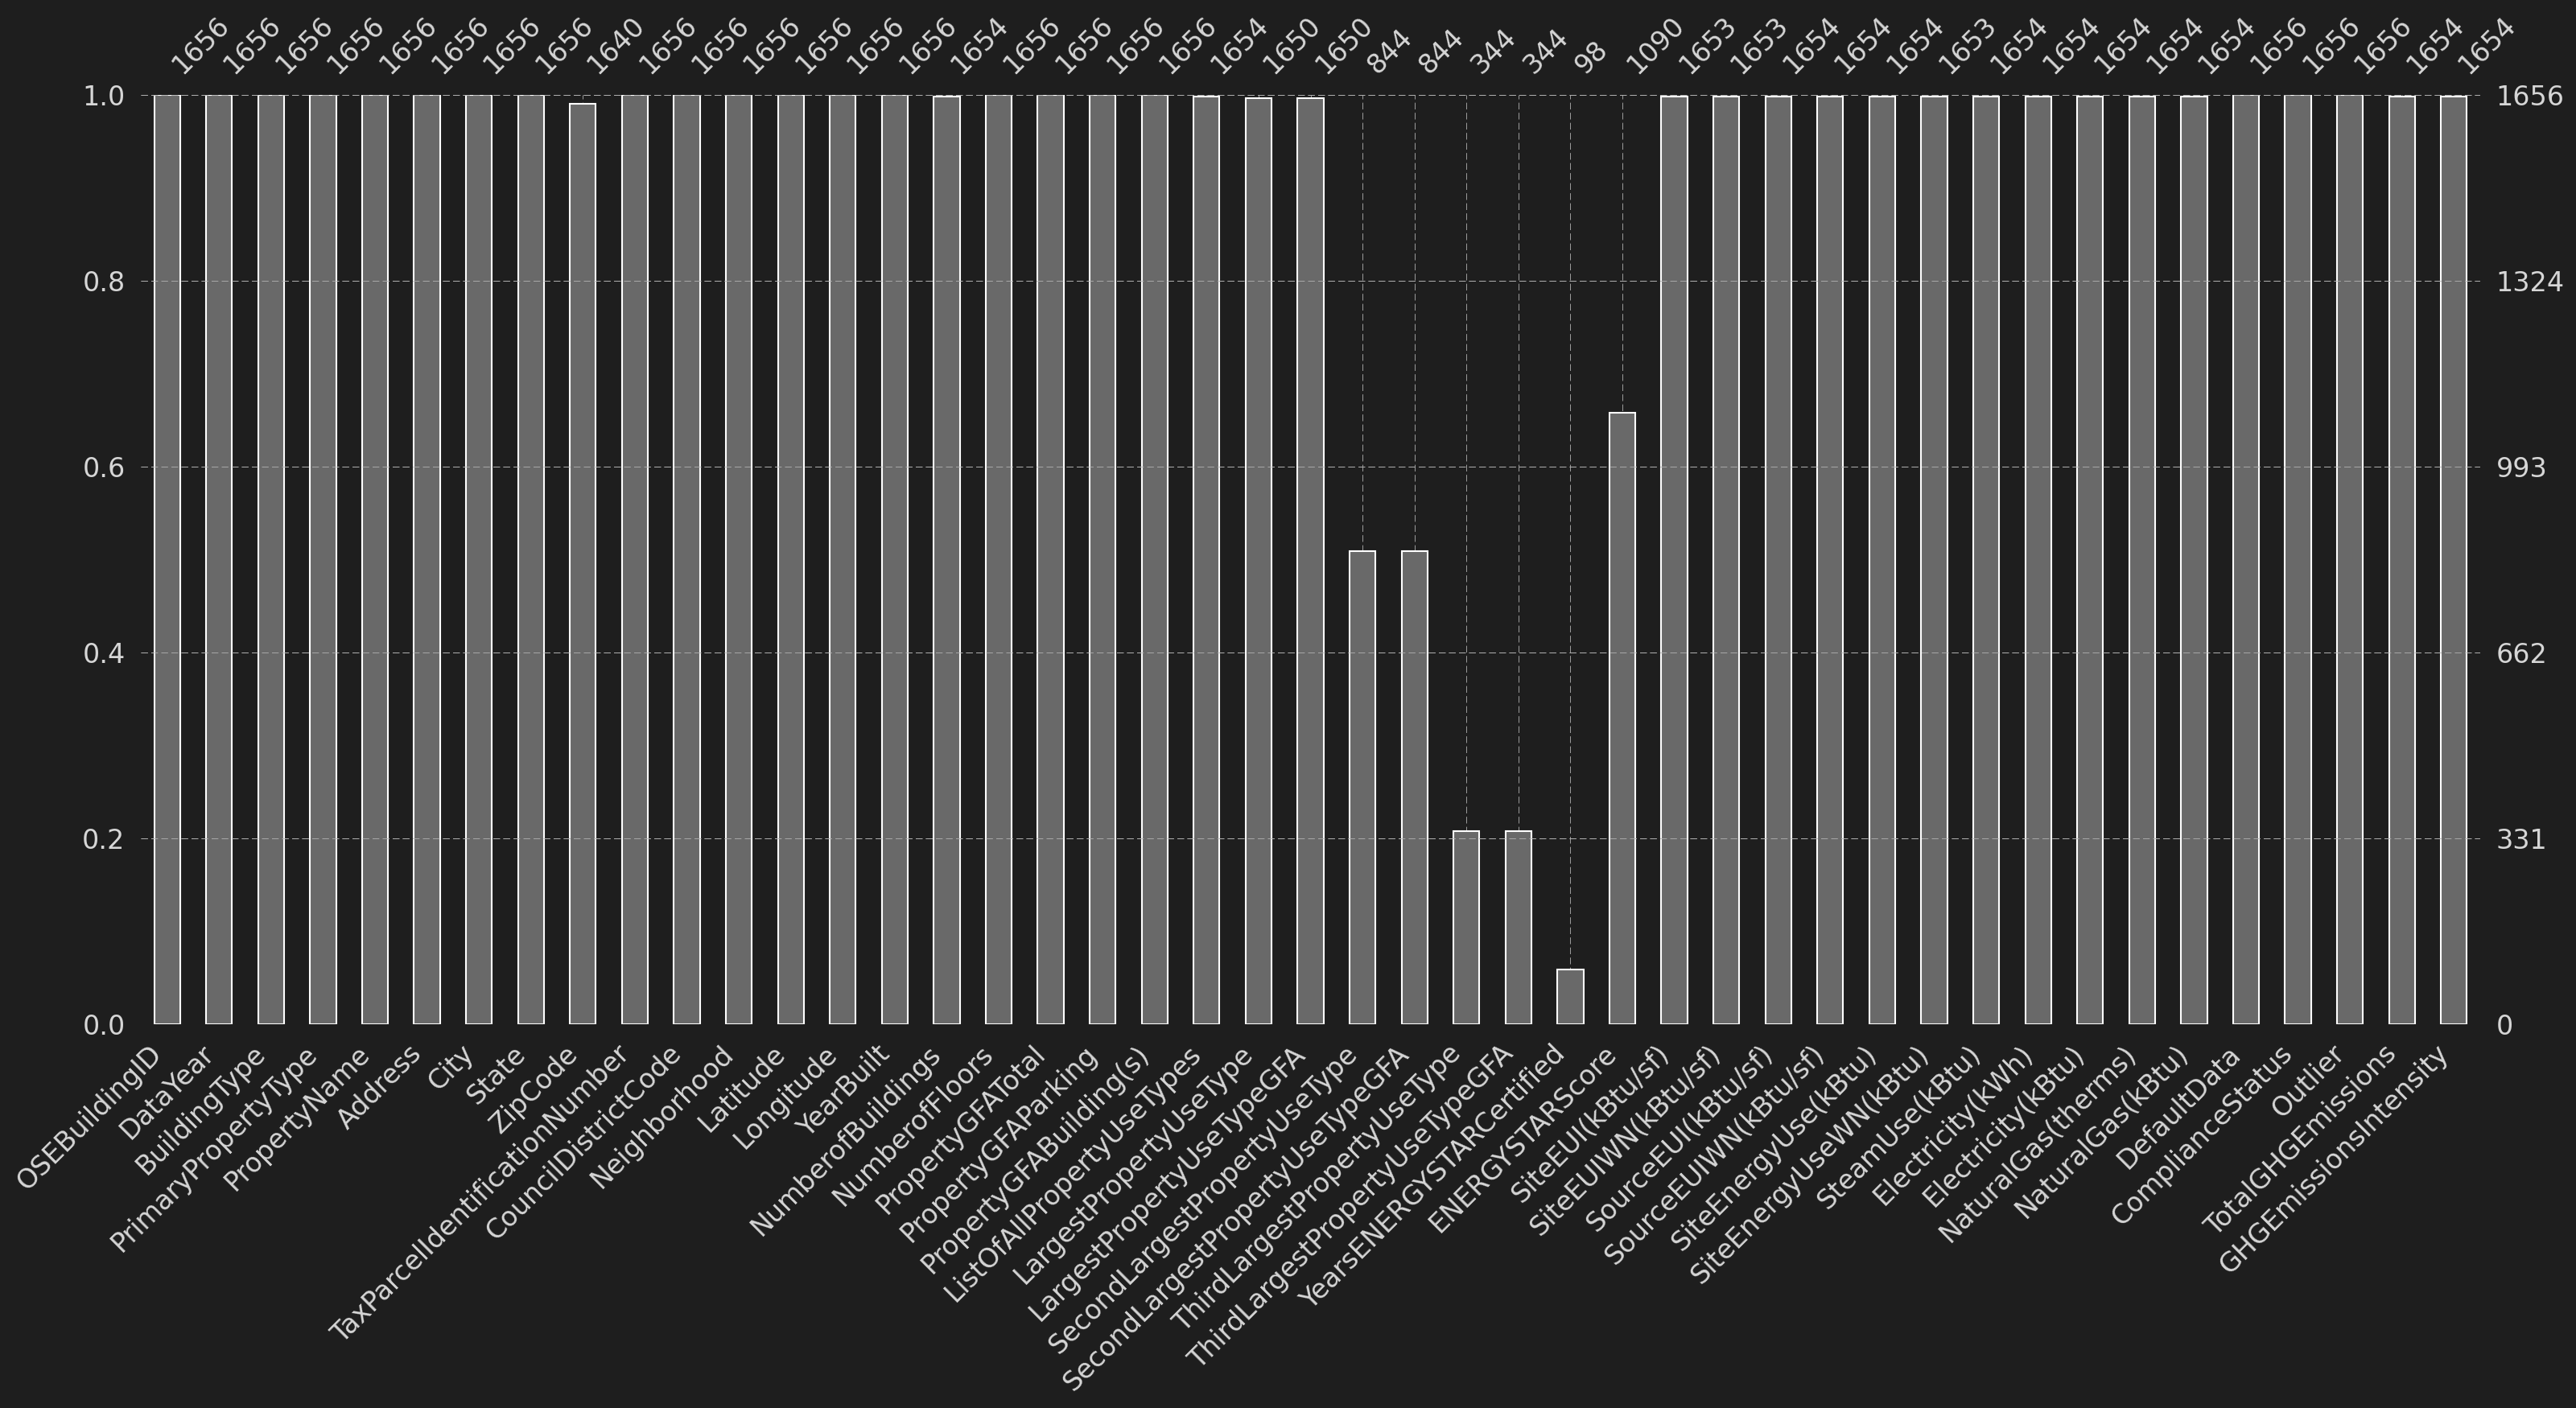

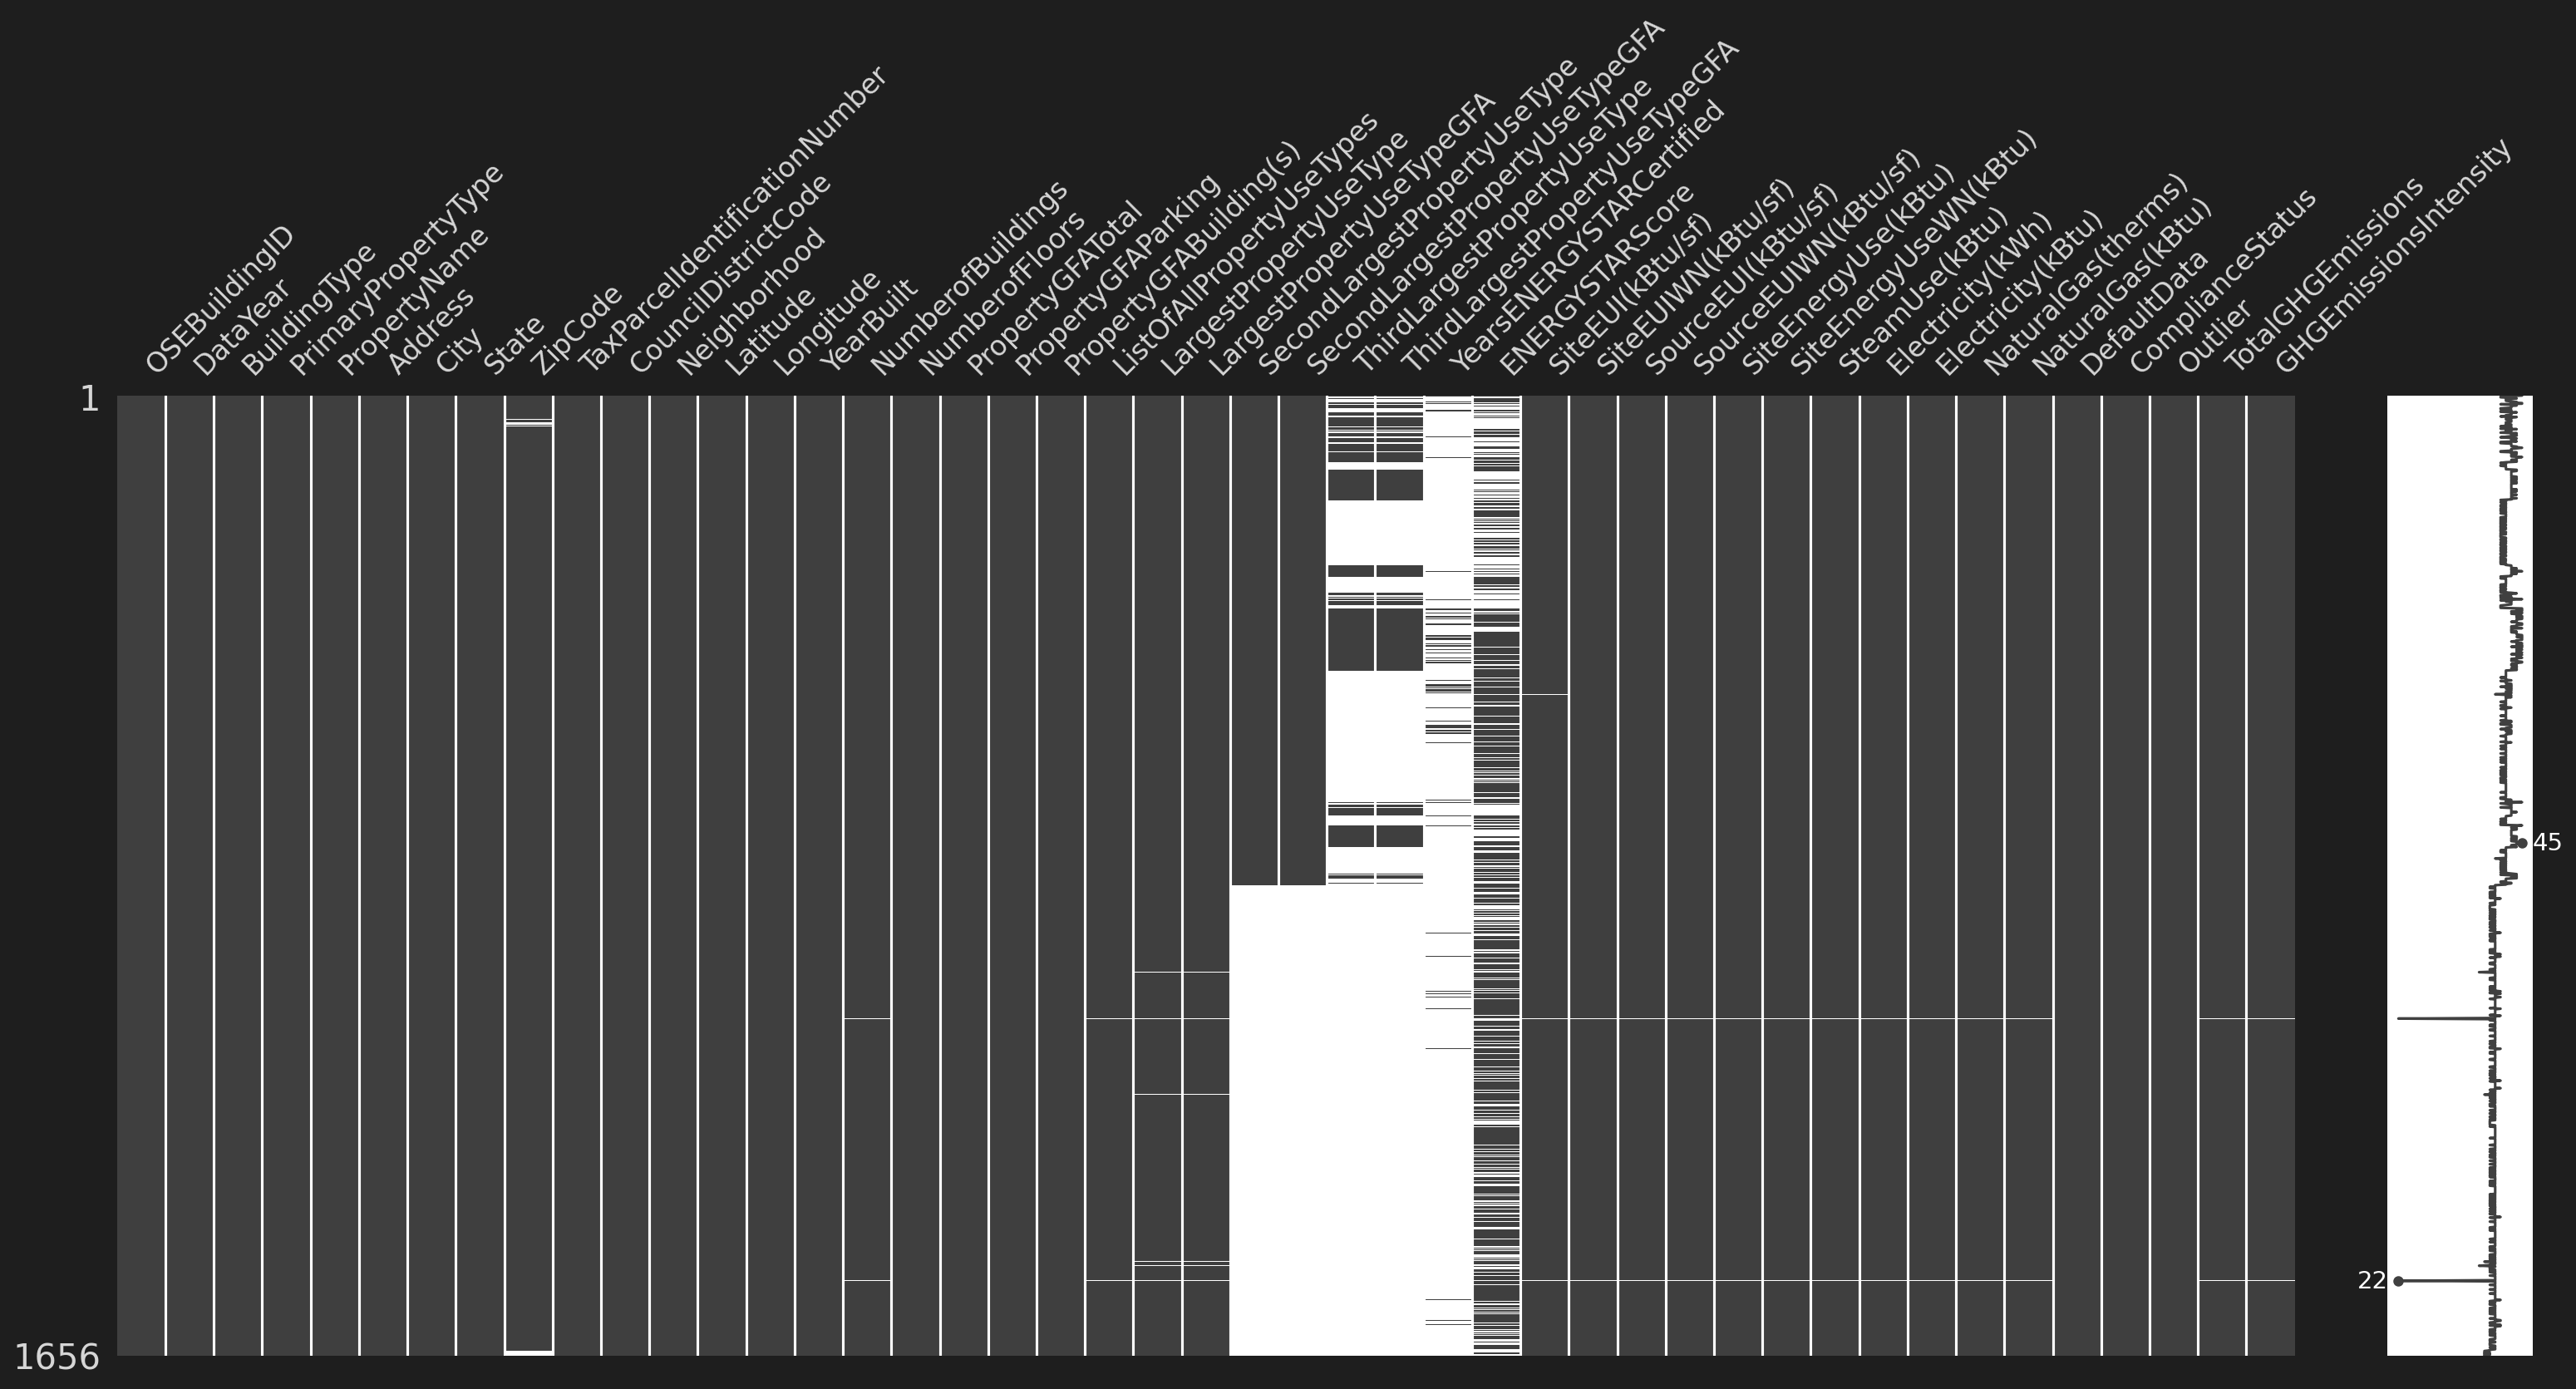

In [21]:
ax = msno.bar( df )

ax = msno.matrix( df.sort_values( by=['SecondLargestPropertyUseType','ThirdLargestPropertyUseType'] ) )


Il y a clairement des lignes avec un gros manque d'informations -> à enlever
- sur les energy : fillna(0) + sum(1) == 0 -> drop
- LargestPropertyUse : à remplir à partir du PrimaryPropertyType 

In [22]:
energy_keys = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
'SteamUse(kBtu)', 
'Electricity(kWh)', 'Electricity(kBtu)',
'NaturalGas(therms)', 'NaturalGas(kBtu)',
'TotalGHGEmissions', 'GHGEmissionsIntensity']

property_use_keys = [ 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']

others = ['NumberofBuildings']

keys = property_use_keys + others + energy_keys

sr_loc = df[keys].isna().sum(1) > 0
print('Entries with empty cells:')
display( df.loc[sr_loc, keys])

# DROP DATA WITHOUT ENERGY INFORMATION / CONSUMPTION
indexes = (df[energy_keys].fillna(0.).sum(1) == 0.)
indexes = indexes[indexes].index
print('indexes to drop:', indexes.values)
df.drop( index=indexes , inplace=True )

print('Entries with empty cells (after drop):')
sr_loc = df[keys].isna().sum(1) > 0
display( df.loc[sr_loc, keys])

Entries with empty cells:


PrimaryPropertyType  \
304                         other   
353         self-storage facility   
563                  large office   
578   small- and mid-sized office   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   
2670           mixed use property   

                              ListOfAllPropertyUseTypes  \
304                          convention center, parking   
353   fitness center/health club/gym, office, other ...   
563                                office, retail store   
578                                                 NaN   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   
2670                                                NaN   

     LargestPropertyUseType  NumberofBuildings  SiteEUI(kBtu/sf)  \
304       convention center                1.0               NaN   
353                     NaN                2.0         47.799999   
563                  office                1.0         39.500000   
578                     NaN                NaN               NaN   
1147                    NaN                1.0         52.200001   
2414                    NaN                1.0         72.199997   
2459                    NaN                1.0         31.200001   
2670                    NaN                NaN               NaN   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
304             0.000000            0.000000              0.000000   
353            51.000000          103.000000            106.400002   
563                  NaN          128.000000              0.000000   
578                  NaN                 NaN                   NaN   
1147           53.500000          150.399994            154.399994   
2414           74.699997          226.600006            234.600006   
2459           32.500000           62.000000             62.799999   
2670                 NaN                 NaN                   NaN   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
304          0.000000e+00           0.000000e+00             0.0   
353          5.697472e+06           6.076957e+06             0.0   
563          5.177270e+06                    NaN             0.0   
578                   NaN                    NaN             NaN   
1147         2.897080e+06           2.968430e+06             0.0   
2414         3.168131e+06           3.280956e+06             0.0   
2459         8.999242e+05           9.358332e+05             0.0   
2670                  NaN                    NaN             NaN   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
304       0.000000e+00                0.0            0.000000   
353       8.814520e+05          3007514.0        26899.582030   
563       1.427645e+06          4871126.0        14160.409180   
578                NaN                NaN                 NaN   
1147      7.428464e+05          2534592.0         3624.875244   
2414      9.285260e+05          3168131.0            0.000000   
2459      1.180853e+05           402907.0         4970.169922   
2670               NaN                NaN                 NaN   

      NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
304                0.0               0.00                   0.00  
353          2689958.0             163.83                   1.47  
563          1416041.0             109.16                   0.83  
578                NaN                NaN                    NaN  
1147          362488.0              36.92                   0.60  
2414               0.0              22.09                   0.46  
2459          497017.0              29.21                   1.01  
2670               NaN                NaN                    NaN

indexes to drop: [  28  152  304  578  746 1361 2670]
Entries with empty cells (after drop):


PrimaryPropertyType  \
353         self-storage facility   
563                  large office   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   

                              ListOfAllPropertyUseTypes  \
353   fitness center/health club/gym, office, other ...   
563                                office, retail store   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   

     LargestPropertyUseType  NumberofBuildings  SiteEUI(kBtu/sf)  \
353                     NaN                2.0         47.799999   
563                  office                1.0         39.500000   
1147                    NaN                1.0         52.200001   
2414                    NaN                1.0         72.199997   
2459                    NaN                1.0         31.200001   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
353            51.000000          103.000000            106.400002   
563                  NaN          128.000000              0.000000   
1147           53.500000          150.399994            154.399994   
2414           74.699997          226.600006            234.600006   
2459           32.500000           62.000000             62.799999   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
353          5.697472e+06           6.076957e+06             0.0   
563          5.177270e+06                    NaN             0.0   
1147         2.897080e+06           2.968430e+06             0.0   
2414         3.168131e+06           3.280956e+06             0.0   
2459         8.999242e+05           9.358332e+05             0.0   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
353       8.814520e+05          3007514.0        26899.582030   
563       1.427645e+06          4871126.0        14160.409180   
1147      7.428464e+05          2534592.0         3624.875244   
2414      9.285260e+05          3168131.0            0.000000   
2459      1.180853e+05           402907.0         4970.169922   

      NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
353          2689958.0             163.83                   1.47  
563          1416041.0             109.16                   0.83  
1147          362488.0              36.92                   0.60  
2414               0.0              22.09                   0.46  
2459          497017.0              29.21                   1.01

### 1.5.2 Remplissage des NaN
On regarde les éléments sans LargestPropertyUseType

In [23]:
vars = ['PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
        'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)',
        'PropertyGFAParking', 'PropertyGFATotal' ]
sr_loc = (df['LargestPropertyUseType'].isna())
display( df.loc[sr_loc,vars])

PrimaryPropertyType  \
353         self-storage facility   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   

                              ListOfAllPropertyUseTypes  \
353   fitness center/health club/gym, office, other ...   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353                     NaN                        NaN   
1147                    NaN                        NaN   
2414                    NaN                        NaN   
2459                    NaN                        NaN   

      PropertyGFABuilding(s)  PropertyGFAParking  PropertyGFATotal  
353                   111445                   0            111445  
1147                   61721                   0             61721  
2414                   48350                   0             48350  
2459                   28800                   0             28800

In [24]:
display( df.loc[ df['PrimaryPropertyType']=="self-storage facility", 'LargestPropertyUseType'].value_counts() )
display( df.loc[ df['PrimaryPropertyType'].str.contains('office'), 'LargestPropertyUseType'].value_counts() )

self-storage facility    27
Name: LargestPropertyUseType, dtype: int64

office            466
medical office     39
Name: LargestPropertyUseType, dtype: int64

À priori on peut replacer les valeurs manquantes de "LargestPropertyUseType(GFA)" par la "PrimaryPropertyType" / le "PropertyGFABuilding(s)".

Note: si présence de "office" dans le "PrimaryPropertyType", alors la valeur est "office" (pas de distinctions pour les "LargestPropertyUseType")

In [25]:
for index in sr_loc[sr_loc].index:
    Primary = df.at[index, 'PrimaryPropertyType']
    df.at[index, 'LargestPropertyUseTypeGFA'] = df.at[index, 'PropertyGFABuilding(s)']
    if 'office' in Primary:
        df.at[index, 'LargestPropertyUseType'] = 'office'
        continue
    df.at[index, 'LargestPropertyUseType'] = Primary

On vérifie le résultat:

In [26]:
display( df.loc[sr_loc,vars] )

PrimaryPropertyType  \
353         self-storage facility   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   

                              ListOfAllPropertyUseTypes  \
353   fitness center/health club/gym, office, other ...   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353   self-storage facility                   111445.0   
1147                  hotel                    61721.0   
2414                 office                    48350.0   
2459             restaurant                    28800.0   

      PropertyGFABuilding(s)  PropertyGFAParking  PropertyGFATotal  
353                   111445                   0            111445  
1147                   61721                   0             61721  
2414                   48350                   0             48350  
2459                   28800                   0             28800

In [27]:
sum_isna = df.isna().sum()
print( 'sum isna > 0:' )
display( sum_isna[sum_isna > 0])

sum isna > 0:


ZipCode                              16
SecondLargestPropertyUseType        806
SecondLargestPropertyUseTypeGFA     806
ThirdLargestPropertyUseType        1305
ThirdLargestPropertyUseTypeGFA     1305
YearsENERGYSTARCertified           1551
ENERGYSTARScore                     560
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

Remplissage du ZipCode à partir de la longitude et de la latitude: toutes les données étant à Seattle, les variables `Longitude` et `Latitude` peuvent être utilisée comme (`x`,`y`).

Si il y avait plus d'écarts entre les positions, possibilité d'utilisé le package `haversine`.

In [28]:
sr_loc = df['ZipCode'].isna()
for index in sr_loc[sr_loc].index:
    x,y = df.loc[index, ['Longitude', 'Latitude']].values
    for value in df['Longitude']:
        if isinstance( value, str):
            print('value:', value)
    df['Longitude'].values-x
    df['Latitude'].values-y
    argsort = ((df['Longitude'].values-x)**2 + (df['Latitude'].values-y)**2).argsort()
    for i in argsort[1:]: # neglect the first as it corresponds to the current index
        if np.isnan( df['ZipCode'].iloc[i] ) :
            continue
        df.at[index, 'ZipCode'] = df['ZipCode'].iloc[i]
        break 
    # print('\nx,y:', x,y, '\nx2,y2:', df[['Longitude','Latitude']].iloc[i,:].values )

sum_isna = df.isna().sum()
print( 'After procees sum isna > 0:' )
display( sum_isna[sum_isna > 0])

After procees sum isna > 0:


SecondLargestPropertyUseType        806
SecondLargestPropertyUseTypeGFA     806
ThirdLargestPropertyUseType        1305
ThirdLargestPropertyUseTypeGFA     1305
YearsENERGYSTARCertified           1551
ENERGYSTARScore                     560
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

***
# 2. Vérifications des données d'entrée

In [29]:
df.keys()

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHG

## 2.1 Value_counts

In [30]:
len(df)

1649

In [31]:
vars = ['BuildingType', 'PrimaryPropertyType',
       'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType',
       ]
for var in vars:
    print( f'{var} value_counts:')
    display( df[var].value_counts() )

BuildingType value_counts:


nonresidential        1445
sps-district k-12       95
nonresidential cos      85
campus                  23
nonresidential wa        1
Name: BuildingType, dtype: int64

PrimaryPropertyType value_counts:


small- and mid-sized office    291
other                          248
warehouse                      187
large office                   173
k-12 school                    136
mixed use property             104
retail store                    91
hotel                           76
worship facility                71
distribution center             53
supermarket / grocery store     40
medical office                  39
self-storage facility           28
university                      24
residence hall                  21
senior care community           20
refrigerated warehouse          12
restaurant                      12
hospital                        10
laboratory                      10
office                           3
Name: PrimaryPropertyType, dtype: int64

Neighborhood value_counts:


downtown                 355
greater duwamish         346
magnolia / queen anne    150
lake union               146
northeast                126
east                     118
northwest                 85
ballard                   70
north                     65
central                   54
delridge                  47
southeast                 46
southwest                 41
Name: Neighborhood, dtype: int64

NumberofBuildings value_counts:


1.0      1545
0.0        52
2.0        14
3.0        12
5.0         7
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: NumberofBuildings, dtype: int64

NumberofFloors value_counts:


1     462
2     389
3     264
4     142
5     101
6      82
7      34
8      22
10     18
11     18
0      16
14      9
12      9
9       8
13      7
15      6
42      5
19      5
17      4
29      3
22      3
21      3
23      3
16      3
18      3
20      3
24      3
25      3
33      3
34      2
36      2
41      2
56      1
28      1
76      1
27      1
46      1
30      1
47      1
55      1
63      1
37      1
49      1
99      1
Name: NumberofFloors, dtype: int64

LargestPropertyUseType value_counts:


office                                                  498
non-refrigerated warehouse                              199
k-12 school                                             136
retail store                                             99
other                                                    98
hotel                                                    77
worship facility                                         71
distribution center                                      54
supermarket/grocery store                                41
medical office                                           41
other - recreation                                       31
parking                                                  30
self-storage facility                                    28
college/university                                       24
residence hall/dormitory                                 22
other - entertainment/public assembly                    21
senior care community                   

SecondLargestPropertyUseType value_counts:


parking                                                 333
office                                                  165
retail store                                             83
other                                                    45
non-refrigerated warehouse                               30
restaurant                                               29
fitness center/health club/gym                           16
data center                                              13
multifamily housing                                      12
other - services                                         11
laboratory                                                8
supermarket/grocery store                                 8
medical office                                            8
distribution center                                       7
bank branch                                               7
other - entertainment/public assembly                     6
k-12 school                             

ThirdLargestPropertyUseType value_counts:


office                                                  49
retail store                                            46
parking                                                 42
other                                                   38
restaurant                                              31
non-refrigerated warehouse                              15
data center                                             14
multifamily housing                                     12
swimming pool                                           10
medical office                                           9
food service                                             8
pre-school/daycare                                       8
social/meeting hall                                      7
bank branch                                              5
other - restaurant/bar                                   5
financial office                                         4
fitness center/health club/gym                          

## 2.2 Number of floors
On regarde les number of floors pour voir si il y a des valeurs aberrantes

Text(2100000.0, 82, 'valeur aberrantes :\nseattle chinese baptist church')

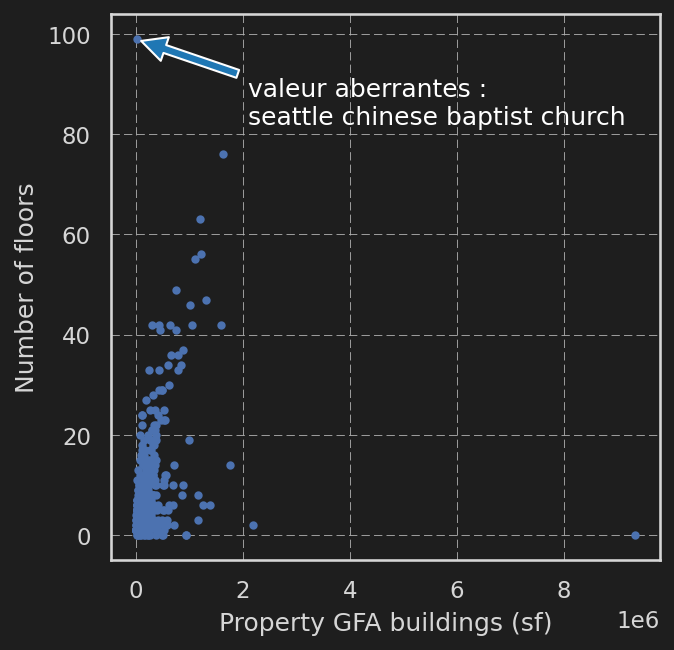

In [32]:
X, Y = 'PropertyGFABuilding(s)', 'NumberofFloors'

fig, ax = plt.subplots( figsize=(12*cm,12*cm) )
ax.plot( df[X], df[Y], 'bo', markersize=3 )

ax.set_ylabel( 'Number of floors' )
ax.set_xlabel( 'Property GFA buildings (sf)' )

index_100 = df[Y] > 90
index_100 = index_100[index_100].index.values[0]

ax.annotate( 'valeur aberrantes :\n{:}'.format( 
                df.at[index_100, 'PropertyName'] ),
                xy=[0, 99], xytext=[2.1e6, 82],# ha='left', va='center',
                arrowprops=dict(shrink=0.05) )

On assigne la valeur la plus utilisée pour NumberofFloors: 1, sachant que la surface est relativement faible.

In [33]:
df.at[index_100, Y] = 1

## 2.3 histogramme / transformation

YearBuilt  PropertyGFATotal  PropertyGFAParking  \
count  1649.000000      1.649000e+03         1649.000000   
mean   1961.882959      1.181488e+05        12938.008490   
std      32.661180      2.963782e+05        42426.306593   
min    1900.000000      1.128500e+04            0.000000   
25%    1930.000000      2.940000e+04            0.000000   
50%    1965.000000      4.929900e+04            0.000000   
75%    1989.000000      1.060000e+05            0.000000   
max    2015.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            1.649000e+03               1.649000e+03   
mean             1.052108e+05               9.850653e+04   
std              2.832035e+05               2.766470e+05   
min              3.636000e+03               5.656000e+03   
25%              2.842500e+04               2.562000e+04   
50%              4.755400e+04               4.400000e+04   
75%              9.471300e+04               9.200600e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                       843.000000                      344.000000   
mean                      35957.489083                    14636.044764   
std                       65987.207732                    36612.789464   
min                           0.000000                        0.000000   
25%                        5222.500000                     2587.750000   
50%                       12000.000000                     5744.000000   
75%                       31795.500000                    12369.250000   
max                      639931.000000                   459748.000000   

       NumberofBuildings  NumberofFloors  
count        1649.000000     1649.000000  
mean            1.167981        4.050334  
std             2.944930        6.110870  
min             0.000000        0.000000  
25%             1.000000        1.000000  
50%             1.000000        2.000000  
75%             1.000000        4.000000  
max           111.000000       76.000000

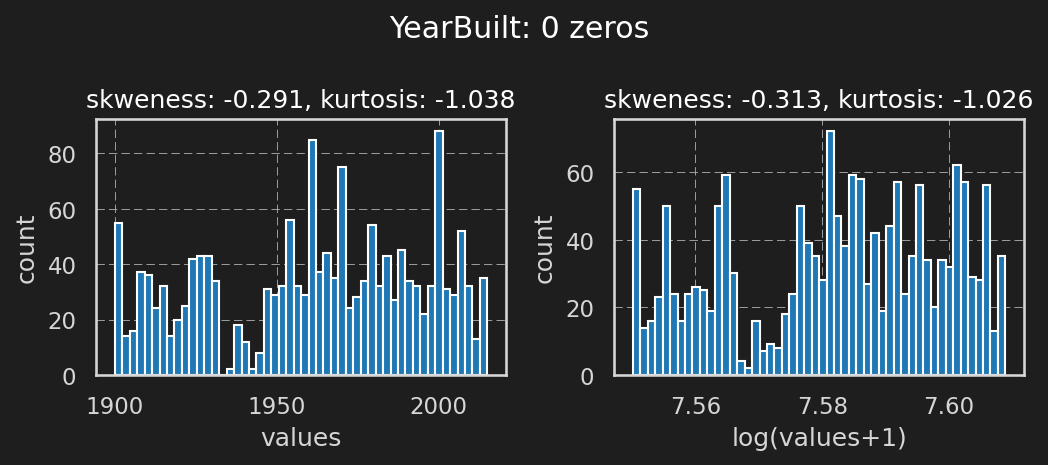

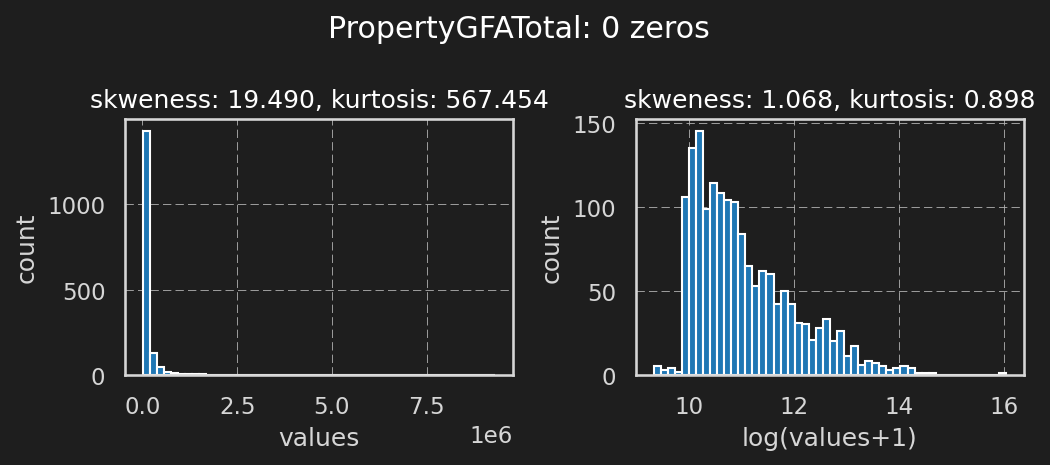

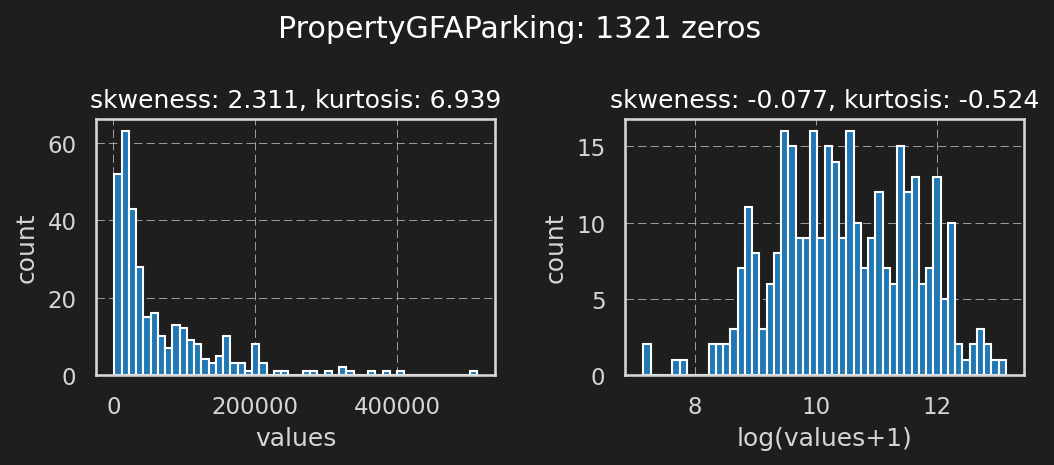

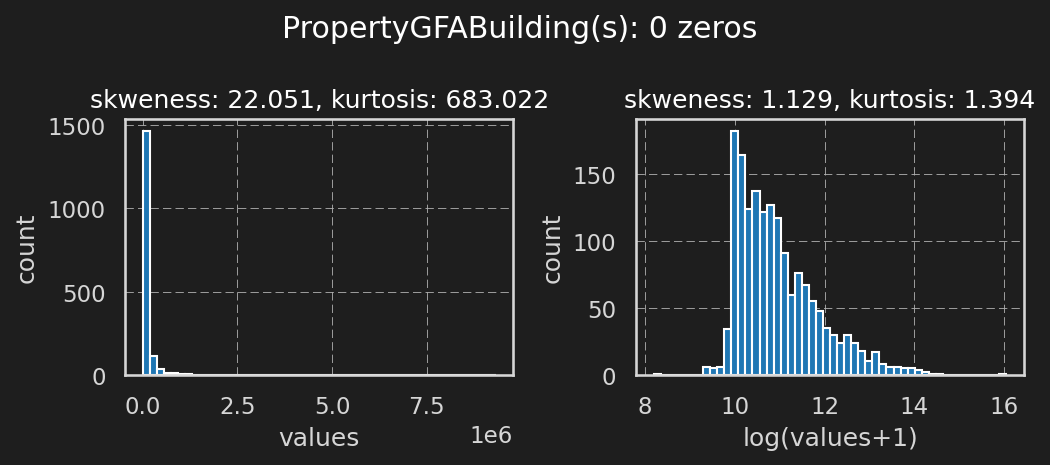

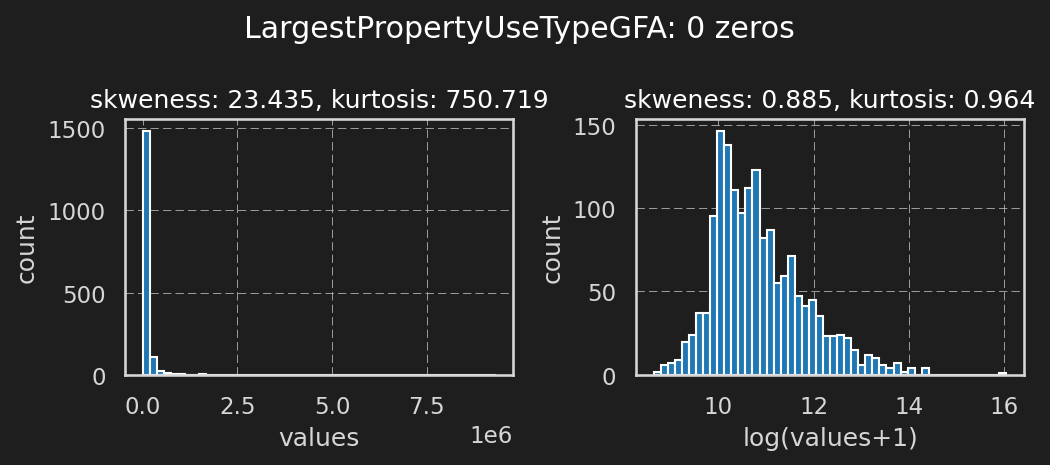

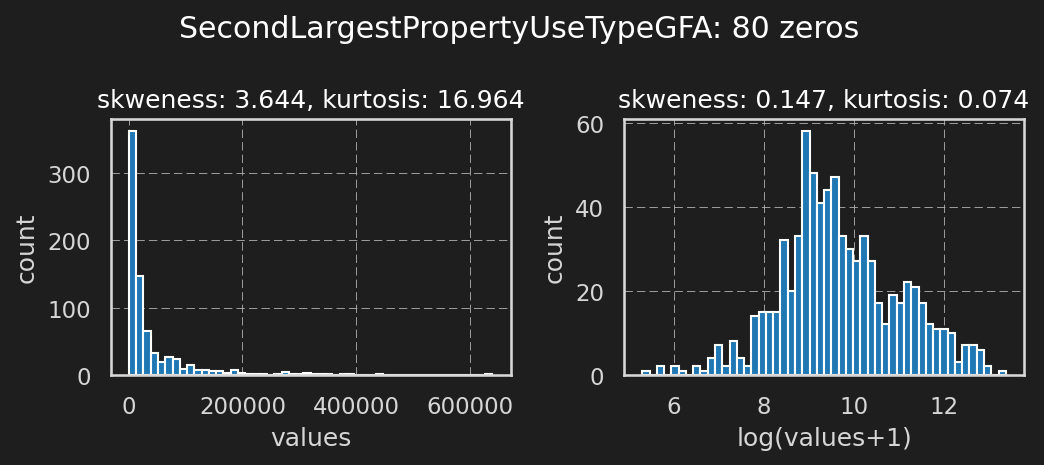

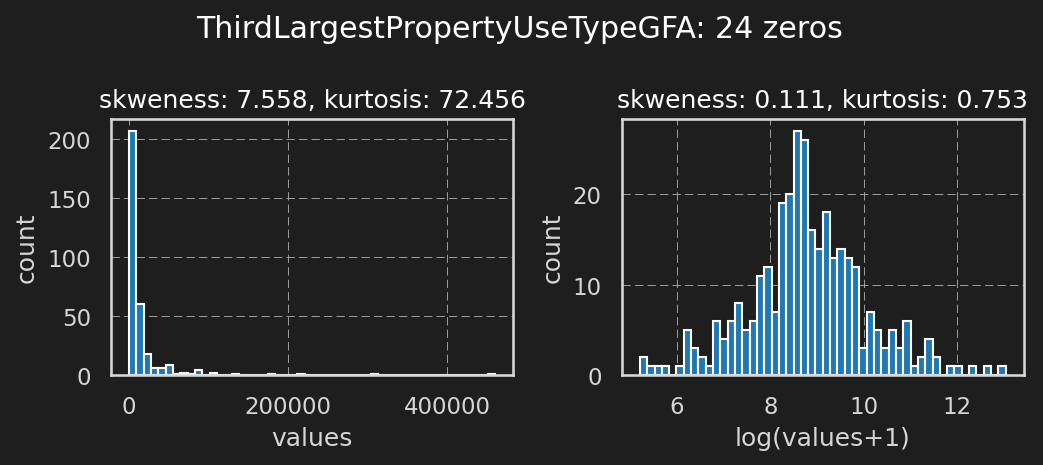

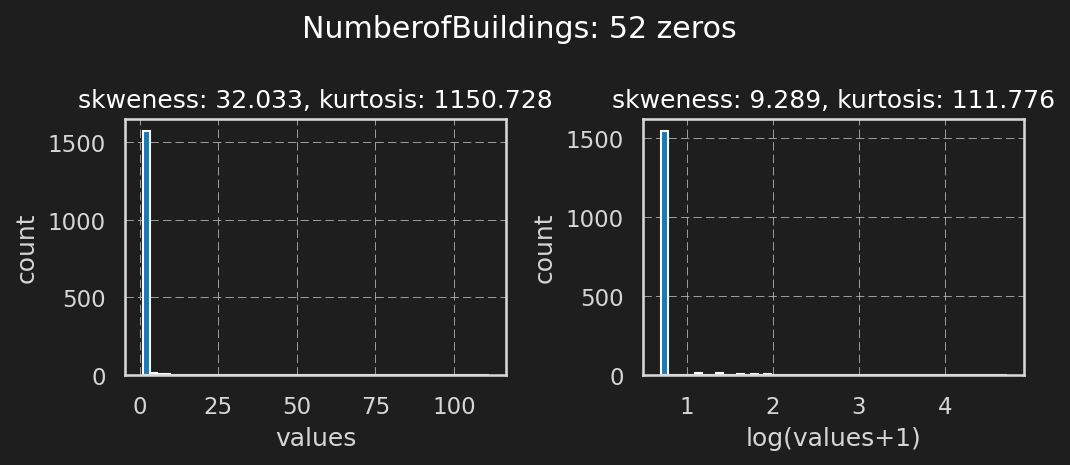

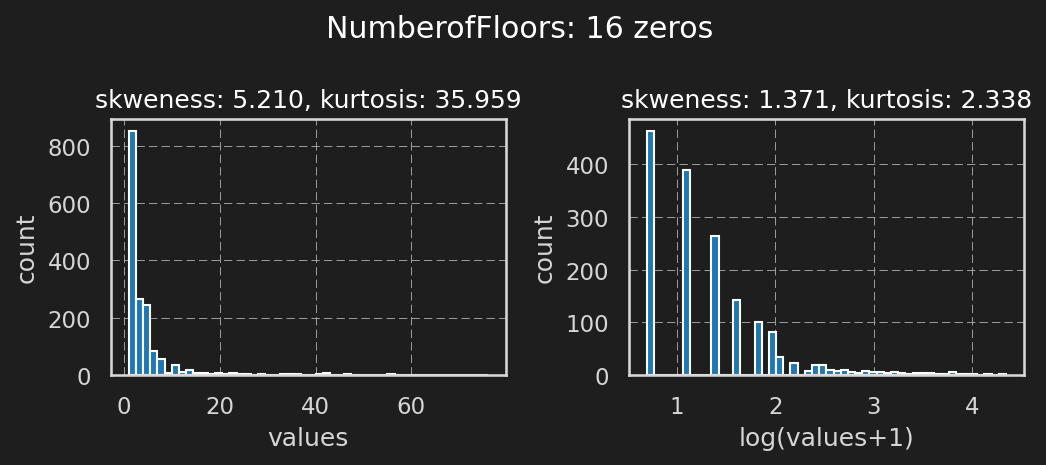

In [34]:
vars = ['YearBuilt', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 
       'SecondLargestPropertyUseTypeGFA', 
       'ThirdLargestPropertyUseTypeGFA',
       'NumberofBuildings', 'NumberofFloors']

exponents = [1, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.1, 0.1]

display( df[vars].describe() )
for var, expo in zip(vars, exponents):
    values = df[var].dropna()
    n_zeros = (values==0).sum()
    values = values[values !=0]
    kurtosis = st.kurtosis( values )
    skew = st.skew( values )

    fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm))
    fig.suptitle( f'{var}: {n_zeros} zeros'  )
    axs[0].hist( values, bins=50 )
    axs[0].set_xlabel( 'values'  )
    axs[0].set_ylabel( 'count' )
    axs[0].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    # values = values**expo
    values = np.log(values + 1)
    kurtosis = st.kurtosis( values )
    skew = st.skew( values )
    axs[1].hist( values, bins=50 )
    axs[1].set_xlabel( 'log(values+1)' )
    axs[1].set_ylabel( 'count' )
    axs[1].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    fig.tight_layout()


## 2.4 autres vérifications

Certains `NumberofBuildings` sont particulièrement élevés, mais à priori OK.

In [35]:
mask = 'NumberofBuildings'
df.loc[ df[mask] > 5, :].sort_values( by=mask )

OSEBuildingID  DataYear        BuildingType  \
124             198      2016      nonresidential   
167             268      2016      nonresidential   
364             516      2016      nonresidential   
2901          27389      2016      nonresidential   
618             828      2016      nonresidential   
1672          23071      2016      nonresidential   
3168          49705      2016  nonresidential cos   
170             276      2016      nonresidential   
1993          24086      2016              campus   
128             211      2016              campus   
162             261      2016              campus   
2325          25251      2016              campus   
1862          23622      2016              campus   
105             172      2016              campus   
3274          49967      2016              campus   

              PrimaryPropertyType  \
124                      hospital   
167                      hospital   
364                         other   
2901  small- and mid-sized office   
618                      hospital   
1672                     hospital   
3168                        other   
170                      hospital   
1993                        other   
128                    university   
162                  large office   
2325                   university   
1862                        other   
105                    university   
3274                   university   

                                           PropertyName  \
124             seattle children's hospital main campus   
167                                 swedish cherry hill   
364                              aurora shopping center   
2901                                  leschi lakecenter   
618                                  swedish first hill   
1672                          main hospital - all wings   
3168                                           magnuson   
170                           harborview medical center   
1993  (id#24086)campus1:kc metro transit atlantic ce...   
128                                    nscc main campus   
162                                          south park   
2325                            5th avenue master meter   
1862                          ft c15 fishermen's center   
105                                    sscc main campus   
3274          university of washington - seattle campus   

                              Address     City State  ZipCode  \
124            4800 sand point way ne  seattle    wa  98105.0   
167                      500 17th ave  seattle    wa  98122.0   
364         13201 aurora avenue north  seattle    wa  98133.0   
2901                     120 lakeside  seattle    wa  98122.0   
618                      747 broadway  seattle    wa  98122.0   
1672  facilities management ms: b-120  seattle    wa  98133.0   
3168           7400 sand point way ne  seattle    wa  98115.0   
170                      325 9th ave.  seattle    wa  98104.0   
1993               1333 airport way s  seattle    wa  98134.0   
128                9600 college way n  seattle    wa  98103.0   
162                    1420 s trenton  seattle    wa  98108.0   
2325                  3307 3rd ave. w  seattle    wa  98119.0   
1862       1900 west nickerson street  seattle    wa  98119.0   
105                  6000 16th ave sw  seattle    wa  98106.0   
3274        ne 45th st & brooklyn ave  seattle    wa  98105.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
124                     2982800005                    4   
167                     7942600331                    3   
364                     1926049215                    5   
2901                    4114601145                    3   
618                     1978201096                    3   
1672                    3026049130                    5   
3168                    0225049062                    4   
170                     8590900220                    3   
1993                    7666203387             

Signification `NumberofFLoors` == 0 ? pas d'étage ?

Pour la `seattle chinese baptist church` 99 floors n'est pas cohérent (surtout en regardant l'image satellite): elle a donc été remplacée par 1 

In [36]:
mask = 'NumberofFloors'
df.sort_values( by=mask, ascending=False ).iloc[:10,:]

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
559            775      2016      nonresidential        large office   
233            357      2016  nonresidential cos        large office   
292            422      2016      nonresidential        large office   
271            399      2016      nonresidential        large office   
229            353      2016      nonresidential        large office   
221            345      2016      nonresidential        large office   
273            402      2016      nonresidential        large office   
261            388      2016      nonresidential        large office   
231            355      2016      nonresidential        large office   
256            383      2016      nonresidential        large office   

                       PropertyName                     Address     City  \
559          columbia center - 2015              701 5th avenue  seattle   
233  seattle municipal tower (2030)            700 fifth avenue  seattle   
292                two union square               601 union st.  seattle   
271               1201 third avenue                1201 3rd ave  seattle   
229                    safeco plaza          1001 fourth avenue  seattle   
221                999 third avenue  999 3rd avenue, suite 1550  seattle   
273                  us bank centre             1420 5th avenue  seattle   
261                   rainier tower                1301 5th ave  seattle   
231                901 fifth avenue            901 fifth avenue  seattle   
256                     smith tower           506 second avenue  seattle   

    State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
559    wa  98104.0                    0942000640                    7   
233    wa  98104.0                    0942000720                    3   
292    wa  98101.0                    1976700125                    7   
271    wa  98101.0                    1974700120                    7   
229    wa  98154.0                    0942000300                    7   
221    wa  98104.0                    0939000435                    7   
273    wa  98101.0                    1975700080                    7   
261    wa  98101.0                    0002400003                    7   
231    wa  98164.0                    0942000365                    7   
256    wa  98104.0                    0939000060                    7   

    Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
559     downtown  47.60454 -122.33072       1985                1.0   
233     downtown  47.60501 -122.32988       1990                1.0   
292     downtown  47.61043 -122.33206       1989                1.0   
271     downtown  47.60723 -122.33611       1988                1.0   
229     downtown  47.60615 -122.33388       1969                1.0   
221     downtown  47.60505 -122.33427       1983                1.0   
273     downtown  47.61054 -122.33466       1989                1.0   
261     downtown  47.60896 -122.33481       1976                1.0   
231     downtown  47.60616 -122.33165       1973                1.0   
256     downtown  47.60198 -122.33174       1912                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
559              76           1952220              319400   
233              63           1354987              159600   
292              56           1605578              389860   
271              55           1400000              285000   
229              49           1123435              368980   
221              47           1323055                   0   
273              46           1536606              512608   
261              42            635824                   0   
231              42            617684              171500   
256              42            304346                   0   

     PropertyGFABuilding(s)  \
559                 1632820   
233                 1195387   
292                 1215

PorpertyGFA : outliers ?

`university of washington - seattle campus` et `entire campus` correspondent à des valeurs `atypique` mais non aberrantes

In [37]:
mask = 'PropertyGFATotal'
describe = df[mask].describe()
print(mask)
display(describe)

print('Q3 + 1.5*IQ = {:.3e}'.format( describe['75%'] 
            + 1.5*(describe['75%']-describe['25%']) ) )

df.sort_values( by=mask, ascending=False ).iloc[:5,:]

PropertyGFATotal


count    1.649000e+03
mean     1.181488e+05
std      2.963782e+05
min      1.128500e+04
25%      2.940000e+04
50%      4.929900e+04
75%      1.060000e+05
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64

Q3 + 1.5*IQ = 2.209e+05


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
3274          49967      2016          campus          university   
1494          22062      2016          campus          university   
559             775      2016  nonresidential        large office   
618             828      2016  nonresidential            hospital   
292             422      2016  nonresidential        large office   

                                   PropertyName                    Address  \
3274  university of washington - seattle campus  ne 45th st & brooklyn ave   
1494                              entire campus            901 12th avenue   
559                      columbia center - 2015             701 5th avenue   
618                          swedish first hill               747 broadway   
292                            two union square              601 union st.   

         City State  ZipCode TaxParcelIdentificationNumber  \
3274  seattle    wa  98105.0                    1625049001   
1494  seattle    wa  98122.0                    2254500880   
559   seattle    wa  98104.0                    0942000640   
618   seattle    wa  98122.0                    1978201096   
292   seattle    wa  98101.0                    1976700125   

      CouncilDistrictCode Neighborhood   Latitude   Longitude  YearBuilt  \
3274                    4    northeast  47.656440 -122.310410       1900   
1494                    3         east  47.610650 -122.317110       1939   
559                     7     downtown  47.604540 -122.330720       1985   
618                     3         east  47.608951 -122.322402       1994   
292                     7     downtown  47.610430 -122.332060       1989   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3274              111.0               0           9320156                   0   
1494                1.0               2           2200000                   0   
559                 1.0              76           1952220              319400   
618                 7.0              14           1765970                   0   
292                 1.0              56           1605578              389860   

      PropertyGFABuilding(s)                       ListOfAllPropertyUseTypes  \
3274                 9320156                              college/university   
1494                 2200000                     college/university, parking   
559                  1632820                                 office, parking   
618                  1765970  hospital (general medical & surgical), parking   
292                  1215718                          office, other, parking   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
3274                     college/university                  9320156.0   
1494                     college/university                  1719643.0   
559                                  office                  1680937.0   
618   hospital (general medical & surgical)                  1639334.0   
292                                  office                  1314475.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3274                          NaN                              NaN   
1494                      parking                         318960.0   
559                       parking                         319368.0   
618                       parking                         441551.0   
292                       parking                         389860.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3274                         NaN                             NaN   
1494                         NaN                             NaN   
559                          NaN                             NaN   
618                          NaN                             NaN   
292                        other                         30744.0   

          YearsENERGYSTARCertified  ENERGYSTARSco

In [38]:
mask = 'PropertyGFAParking'
describe = df[mask].describe()
print(mask)
display(describe.T)
df.sort_values( by=mask, ascending=False ).iloc[:5,:]

PropertyGFAParking


count      1649.000000
mean      12938.008490
std       42426.306593
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
273            402      2016  nonresidential        large office   
307            438      2016  nonresidential      medical office   
292            422      2016  nonresidential        large office   
229            353      2016  nonresidential        large office   
163            263      2016  nonresidential               other   

           PropertyName                Address     City State  ZipCode  \
273      us bank centre        1420 5th avenue  seattle    wa  98101.0   
307  1101 madison tower           1101 madison  seattle    wa  98104.0   
292    two union square          601 union st.  seattle    wa  98101.0   
229        safeco plaza     1001 fourth avenue  seattle    wa  98154.0   
163          building 1  316 ne thornton place  seattle    wa  98125.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
273                    1975700080                    7     downtown  47.61054   
307                    1978200625                    3         east  47.60921   
292                    1976700125                    7     downtown  47.61043   
229                    0942000300                    7     downtown  47.60615   
163                    8632880000                    5        north  47.70281   

     Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
273 -122.33466       1989                1.0              46   
307 -122.32425       1992                1.0              14   
292 -122.33206       1989                1.0              56   
229 -122.33388       1969                1.0              49   
163 -122.32532       2008                1.0               6   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
273           1536606              512608                 1023998   
307            690158              407795                  282363   
292           1605578              389860                 1215718   
229           1123435              368980                  754455   
163            419848              335109                   84739   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
273  financial office, office, other, parking, rest...                 office   
307                            medical office, parking         medical office   
292                             office, other, parking                 office   
229  financial office, food sales, office, other, p...                 office   
163  fast food restaurant, medical office, movie th...                parking   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
273                  1002403.0                      parking   
307                   270384.0                      parking   
292                  1314475.0                      parking   
229                   808980.0                      parking   
163                   335109.0                movie theater   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
273                         377046.0                       other   
307                         270383.0                         NaN   
292                         389860.0                       other   
229                         232248.0                       other   
163                          65000.0              medical office   

     ThirdLargestPropertyUseTypeGFA              YearsENERGYSTARCertified  \
273                         53116.0  201720162014201320122011201020092007   
307                             NaN                      2012201020072006   
292                         30744.0                              20092005   
229                         30329.0                  20162015201420122008   
163                         13567.0                                   NaN   

     ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
273             89.0         51.900002           53.599998   
30

## 2.5 Categories "LargestPropertyUseType"

Liste des catégories

In [39]:

tmp = pd.DataFrame( {'A':['a','a','b','c','c','c'],
                    'B':['b','b','c','d','d','e']})
display( tmp['A'].value_counts() )
display( tmp['B'].value_counts() )
display( tmp['A'].value_counts().add( tmp['B'].value_counts() , fill_value=0 ).astype(int)  )

c    3
a    2
b    1
Name: A, dtype: int64

b    2
d    2
c    1
e    1
Name: B, dtype: int64

a    2
b    3
c    4
d    2
e    1
dtype: int64

In [40]:
df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int).sort_values()

wholesale club/supercenter                                1
police station                                            1
residential care facility                                 1
fire station                                              1
fast food restaurant                                      1
enclosed mall                                             1
food sales                                                2
other - technology/science                                2
courthouse                                                2
lifestyle center                                          2
vocational school                                         2
convenience store without gas station                     3
other - utility                                           3
prison/incarceration                                      3
bar/nightclub                                             3
library                                                   4
movie theater                           

In [41]:
df.loc[ df['LargestPropertyUseType'].str.contains('other - entertainment/public assembly', na=False), 'PropertyName']

7              paramount theatre
47                 mann building
97                 benaroya hall
155                  centurylink
158                 safeco field
185                  act theatre
197             seattle aquarium
373           seattle art museum
625                   emp museum
922         neptune theatre bldg
1257           town hall seattle
1293            showbox building
1634    seattle asian art museum
2139                        sodo
2183      (id24701) showbox sodo
2381               art marble 21
2512     swedish cultural center
2521        mlk community center
2568        (id26126) the summit
2607                4130 1st ave
2904      the greenlind building
Name: PropertyName, dtype: object

In [42]:
masks = ['LargestPropertyUseType','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
for mask in masks:
    display( df.loc[df[mask].str.contains('recreation', na=False), mask].value_counts() )

other - recreation    31
Name: LargestPropertyUseType, dtype: int64

other - recreation    4
Name: SecondLargestPropertyUseType, dtype: int64

other - recreation    2
Name: ThirdLargestPropertyUseType, dtype: int64

In [43]:
categories_keys = [ ('store', ['wholesale', 'mall', 'store', 'dealership'] ),
                    ('utility', ['fire', 'utility', 'police', 'courthouse', 'prison', 'bank']),
                    ('restaurant', ['food', 'restaurant']),
                    ('residential - hotel', ['residential', 'housing', 'hotel', 'dormitory']),
                    ('education', ['school', 'education', 'university']),
                    ('medical', ['care', 'hospital']),
                    ('office', ['financial office']),
                    ('entertainment/public assembly', ['theater','nightclub',
                                'recreation', 'swimming', 'performing arts',
                                'library','museum','meeting hall']),
                    ('lifestyle center', ['lifestyle', 'fitness']),
                    ('science', ['technology', 'laboratory']),
                    ('services', ['services'])
             ]
for (category,keys) in categories_keys :
    joint_keys = '|'.join(keys)
    for mask in masks:
        sr_loc = df[mask].str.contains( joint_keys , na=False )
        df.loc[ sr_loc, mask ] = category


value_counts = df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int).sort_values()

print( f'{len(value_counts)} categories')
display( value_counts )

22 categories


manufacturing/industrial plant            11
refrigerated warehouse                    16
science                                   25
utility                                   26
lifestyle center                          27
data center                               30
other - entertainment/public assembly     31
self-storage facility                     33
services                                  37
medical                                   40
medical office                            58
distribution center                       64
worship facility                          75
entertainment/public assembly             90
restaurant                                95
residential - hotel                      134
other                                    181
education                                192
non-refrigerated warehouse               244
store                                    301
parking                                  405
office                                   721
dtype: int

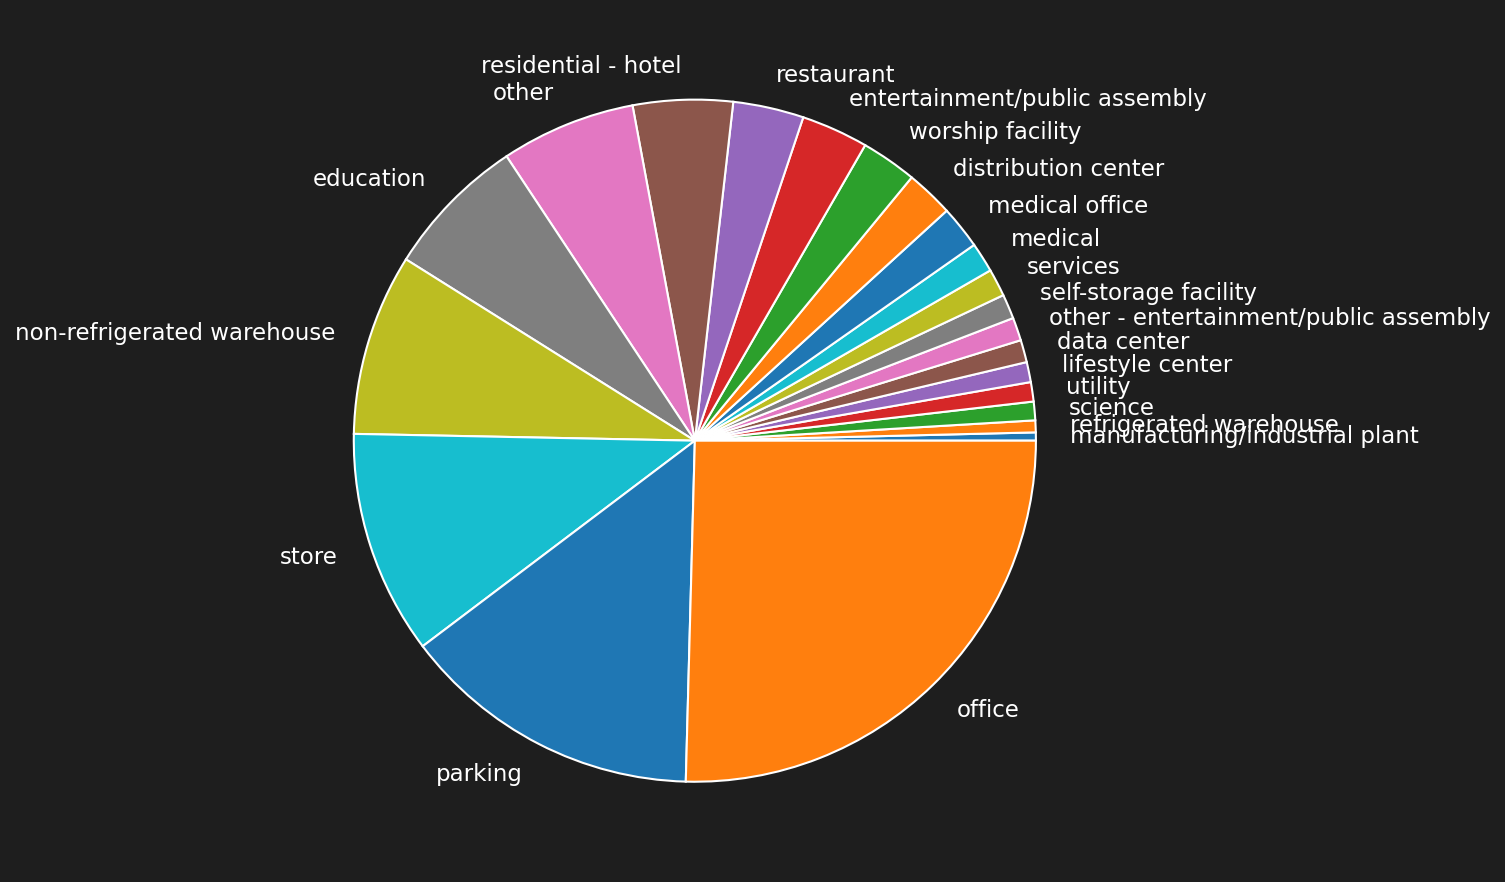

In [44]:
fig, ax = plt.subplots( figsize=(25*cm,25*cm) )
value_counts.plot( kind='pie', ax=ax )
fig.tight_layout()

## 2.6 Year-built -> categories ?
à priori pas de relation directe évidente -> on peut séparer en plusieurs groupes

min: 1900 max: 2015
[1900 1920 1940 1960 1980 2000]


YearBuilt  YearBuiltCateg
1934       1984               6
3110       2013               7
555        1953               4
92         1963               5
868        1923               2
1405       1953               4
692        1979               5
2928       1961               5
1974       1912               1
2324       1959               4

breaks begin at: [1932 1942]
breaks end at: [1935 1944]


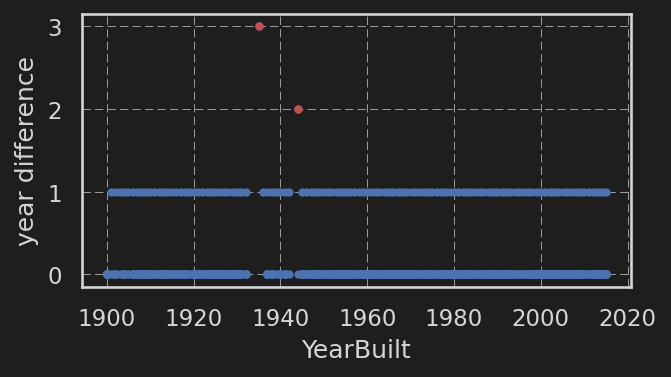

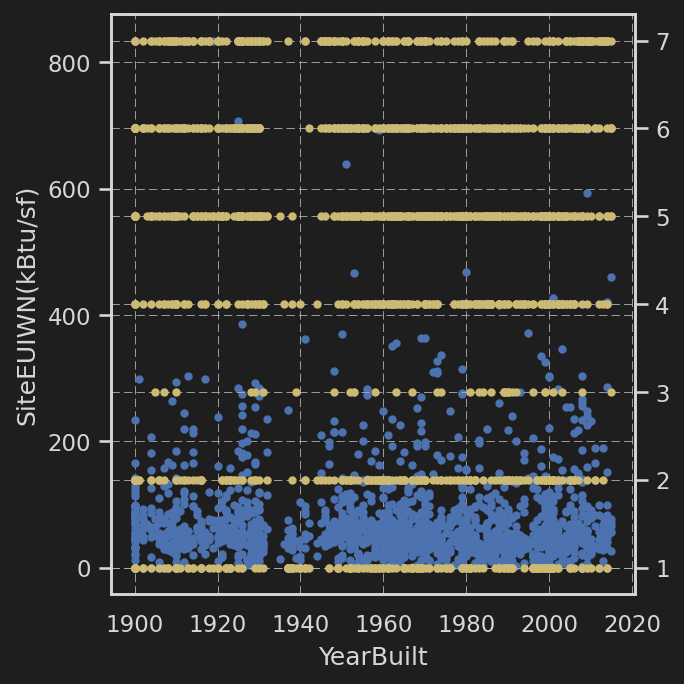

In [45]:
X, Y = 'YearBuilt', 'SiteEUIWN(kBtu/sf)'

print('min:', df[X].min(), 'max:', df[X].max() )
print( np.arange( 1900, 2020, 20 ) )

bins_yearbuilt = [1900, 1920, 1934, 1943, 1960, 1980, 2000, 2020]
df['YearBuiltCateg'] = np.digitize( df[X], bins_yearbuilt )
display( df[[X, 'YearBuiltCateg']].sample(10) )

x = df[X].values
x.sort()
diff_x = x[1:]-x[:-1]
b_break = diff_x > 1
print( 'breaks begin at:', x[:-1][ b_break ])
print( 'breaks end at:', x[1:][ b_break ])

fig, ax = plt.subplots( figsize=(12*cm,6*cm) )
ax.plot( x[1:], diff_x, 'bo', markersize=3 )
ax.plot( x[1:][ b_break ], diff_x[ b_break ], 'ro', markersize=3 )
ax.set_xlabel(X)
ax.set_ylabel( 'year difference' )

fig, ax = plt.subplots( figsize=(12*cm,12*cm) )
ax.plot( df[X], df[Y], 'bo', markersize=3 )
ax_twinx = ax.twinx()
ax_twinx.plot( df[X], df['YearBuiltCateg'], 'yo', markersize=3 )

ax.set_xlabel( X )
ax.set_ylabel( Y )
fig.tight_layout()

***
# 3. PCA

In [46]:
tmp = df.select_dtypes(include=[np.number])
features = [col for col in tmp.columns if not col in vars_to_delete]
print(features)

['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'YearBuiltCateg']


In [47]:
X = df[features].dropna()
scaler_pca = preprocessing.StandardScaler()
X_scaled = scaler_pca.fit_transform(X) # fit and transform
idx = ["mean", "std"]
display( pd.DataFrame(X_scaled).describe().round(2).loc[idx, :] )

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
mean -0.0 -0.0  0.0  0.0  0.0 -0.0 -0.0 -0.0 -0.0  0.0  0.0  0.0 -0.0  0.0   
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       14   15   16   17   18   19   20   21   22   23   24  
mean -0.0  0.0  0.0 -0.0  0.0  0.0 -0.0  0.0 -0.0 -0.0  0.0  
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [48]:
from sklearn.decomposition import PCA
n_components = X_scaled.shape[1]
pca = PCA(n_components=n_components)

# entrainement
pca.fit(X_scaled)

PCA(n_components=25)

scree: [38.06 19.51 13.97  5.18  4.74  3.77  3.28  3.15  2.63  2.07  1.31  0.79
  0.6   0.45  0.23  0.12  0.08  0.04  0.    0.    0.    0.    0.    0.
  0.  ]
sum scree: 100.0


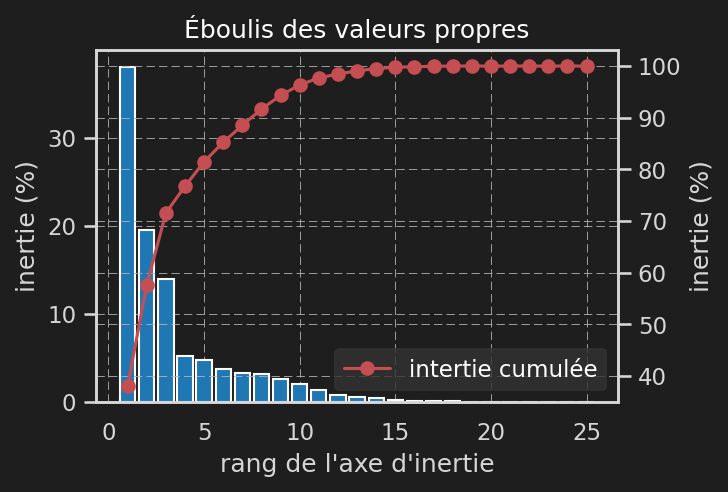

In [49]:
x_list = range(1, n_components+1)
scree = (pca.explained_variance_ratio_*100)
print('scree:', scree.round(2))
print('sum scree:', scree.sum().round(2))
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.bar( x_list, scree )
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("inertie (%)")
ax.set_title('Éboulis des valeurs propres')

ax = ax.twinx()
ax.set_ylabel("inertie (%)")

ax.plot( x_list, scree.cumsum(), c='r', marker='o', label='intertie cumulée')
ax.legend()

fig.tight_layout(pad=0.2)
# tools.savefig( fig, 'Figures/PCA/ebouli.pdf')

La variable `EnergySTARscore` n'impacte que peu les 6 premiers composantes de la PCA

SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  Electricity(kBtu)  \
F1             0.311034               0.309716           0.308293   

    Electricity(kWh)  TotalGHGEmissions  SecondLargestPropertyUseTypeGFA  \
F1          0.308293           0.270917                         0.268551   

    ThirdLargestPropertyUseTypeGFA  NaturalGas(kBtu)  NaturalGas(therms)  \
F1                        0.259827          0.254956            0.254956   

    GHGEmissionsIntensity  LargestPropertyUseTypeGFA  PropertyGFATotal  \
F1               0.237791                   0.221962          0.197973   

    PropertyGFABuilding(s)  NumberofFloors  SiteEUIWN(kBtu/sf)  \
F1                0.197613        0.138631            0.114053   

    PropertyGFAParking  SiteEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
F1            0.113265          0.112696              0.092393   

    SourceEUI(kBtu/sf)  YearBuiltCateg  SteamUse(kBtu)  Outlier  \
F1            0.091897        0.073347        0.032037  0.01353   

    ENERGYSTARScore  NumberofBuildings  YearBuilt  
F1        -0.010637          -0.015602  -0.092063

SiteEUIWN(kBtu/sf)  SiteEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
F2            0.316751          0.313847               0.28826   

    SourceEUI(kBtu/sf)  GHGEmissionsIntensity  NaturalGas(therms)  \
F2            0.287178               0.196523            0.147248   

    NaturalGas(kBtu)  TotalGHGEmissions   Outlier  SiteEnergyUseWN(kBtu)  \
F2          0.147248           0.127845  0.114682               0.074237   

    SiteEnergyUse(kBtu)  YearBuilt  NumberofBuildings  \
F2             0.072179   0.067052            0.01404   

    ThirdLargestPropertyUseTypeGFA  YearBuiltCateg  Electricity(kBtu)  \
F2                       -0.004379       -0.032496          -0.034868   

    Electricity(kWh)  SteamUse(kBtu)  SecondLargestPropertyUseTypeGFA  \
F2         -0.034868       -0.056973                        -0.161912   

    PropertyGFAParking  ENERGYSTARScore  LargestPropertyUseTypeGFA  \
F2           -0.212408        -0.246268                  -0.292978   

    NumberofFloors  PropertyGFABuilding(s)  PropertyGFATotal  
F2       -0.300967               -0.306495         -0.315624

SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEUI(kBtu/sf)  \
F3            0.370875              0.369406          0.319478   

    SiteEUIWN(kBtu/sf)  PropertyGFAParking  NumberofFloors  PropertyGFATotal  \
F3            0.313556            0.222714        0.174254          0.166782   

    YearBuiltCateg  Outlier  PropertyGFABuilding(s)  \
F3         0.15771   0.1572                0.132272   

    LargestPropertyUseTypeGFA  Electricity(kWh)  Electricity(kBtu)  \
F3                   0.124024           0.10809            0.10809   

    ENERGYSTARScore  NumberofBuildings  SecondLargestPropertyUseTypeGFA  \
F3         0.035632           0.031322                         0.007466   

    SteamUse(kBtu)  YearBuilt  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
F3        0.004386  -0.077531            -0.112945              -0.118905   

    ThirdLargestPropertyUseTypeGFA  TotalGHGEmissions  GHGEmissionsIntensity  \
F3                       -0.128916          -0.239309              -0.242134   

    NaturalGas(kBtu)  NaturalGas(therms)  
F3         -0.268558           -0.268558

SteamUse(kBtu)  NumberofBuildings  NumberofFloors  ENERGYSTARScore  \
F4        0.610882           0.355345        0.219753         0.110742   

    GHGEmissionsIntensity  TotalGHGEmissions  SiteEUI(kBtu/sf)  \
F4               0.103234           0.065895          0.058845   

    SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  \
F4            0.031505            0.028108             0.024214   

    SiteEnergyUseWN(kBtu)  LargestPropertyUseTypeGFA  SourceEUIWN(kBtu/sf)  \
F4               0.012621                   0.011371              0.005939   

    NaturalGas(therms)  NaturalGas(kBtu)  Electricity(kWh)  Electricity(kBtu)  \
F4            0.003134          0.003134         -0.012828          -0.012828   

    PropertyGFAParking  PropertyGFABuilding(s)  PropertyGFATotal   Outlier  \
F4           -0.062146               -0.068267         -0.073761 -0.085387   

    SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
F4                        -0.160869                       -0.166836   

    YearBuiltCateg  YearBuilt  
F4       -0.360424  -0.462192

SteamUse(kBtu)  PropertyGFABuilding(s)  ThirdLargestPropertyUseTypeGFA  \
F5        0.217034                0.154828                        0.134854   

     Outlier  LargestPropertyUseTypeGFA  PropertyGFATotal  Electricity(kBtu)  \
F5  0.101707                   0.072634          0.066926           0.062133   

    Electricity(kWh)  NumberofFloors  SourceEUI(kBtu/sf)  \
F5          0.062133        0.035375            0.022941   

    SourceEUIWN(kBtu/sf)  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
F5              0.015496           0.01345            0.003655   

    SecondLargestPropertyUseTypeGFA  YearBuilt  SiteEnergyUse(kBtu)  \
F5                        -0.013507  -0.015314            -0.021561   

    SiteEnergyUseWN(kBtu)  GHGEmissionsIntensity  TotalGHGEmissions  \
F5              -0.027867              -0.057391          -0.064036   

    NaturalGas(kBtu)  NaturalGas(therms)  PropertyGFAParking  ENERGYSTARScore  \
F5         -0.099676           -0.099676           -0.289281         -0.30118   

    YearBuiltCateg  NumberofBuildings  
F5       -0.459915          -0.682546

Outlier  NumberofBuildings  YearBuilt  SteamUse(kBtu)  NumberofFloors  \
F6  0.782912           0.252117   0.249485        0.246459        0.097463   

    YearBuiltCateg  LargestPropertyUseTypeGFA  PropertyGFAParking  \
F6        0.090659                   0.055077            0.044223   

    PropertyGFATotal  PropertyGFABuilding(s)  TotalGHGEmissions  \
F6          0.042682                0.037283           0.036633   

    GHGEmissionsIntensity  SecondLargestPropertyUseTypeGFA  \
F6               0.032462                          0.02703   

    NaturalGas(therms)  NaturalGas(kBtu)  SiteEnergyUse(kBtu)  \
F6            0.016142          0.016142             0.000488   

    SiteEnergyUseWN(kBtu)  Electricity(kBtu)  Electricity(kWh)  \
F6              -0.003406          -0.044452         -0.044452   

    ThirdLargestPropertyUseTypeGFA  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
F6                       -0.054686         -0.082339           -0.095007   

    SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  ENERGYSTARScore  
F6           -0.098308             -0.108762        -0.355922

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
F1      -0.09              -0.02            0.14              0.20   
F2       0.07               0.01           -0.30             -0.32   
F3      -0.08               0.03            0.17              0.17   
F4      -0.46               0.36            0.22             -0.07   
F5      -0.02              -0.68            0.04              0.07   
F6       0.25               0.25            0.10              0.04   

    PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
F1                0.11                    0.20                       0.22   
F2               -0.21                   -0.31                      -0.29   
F3                0.22                    0.13                       0.12   
F4               -0.06                   -0.07                       0.01   
F5               -0.29                    0.15                       0.07   
F6                0.04                    0.04                       0.06   

    SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
F1                             0.27                            0.26   
F2                            -0.16                           -0.00   
F3                             0.01                           -0.13   
F4                            -0.16                           -0.17   
F5                            -0.01                            0.13   
F6                             0.03                           -0.05   

    ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
F1            -0.01              0.11                0.11                0.09   
F2            -0.25              0.31                0.32                0.29   
F3             0.04              0.32                0.31                0.37   
F4             0.11              0.06                0.03                0.03   
F5            -0.30              0.01                0.00                0.02   
F6            -0.36             -0.08               -0.10               -0.10   

    SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
F1                  0.09                 0.31                   0.31   
F2                  0.29                 0.07                   0.07   
F3                  0.37                -0.11                  -0.12   
F4                  0.01                 0.02                   0.01   
F5                  0.02                -0.02                  -0.03   
F6                 -0.11                 0.00                  -0.00   

    SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
F1            0.03              0.31               0.31                0.25   
F2           -0.06             -0.03              -0.03                0.15   
F3            0.00              0.11               0.11               -0.27   
F4            0.61             -0.01              -0.01                0.00   
F5            0.22              0.06               0.06               -0.10   
F6            0.25             -0.04              -0.04                0.02   

    NaturalGas(kBtu)  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  \
F1              0.25     0.01               0.27                   0.24   
F2              0.15     0.11               0.13                   0.20   
F3             -0.27     0.16              -0.24                  -0.24   
F4              0.00    -0.09               0.07                   0.10   
F5             -0.10     0.10              -0.06                  -0.06   
F6              0.02     0.78               0.04                   0.03   

    YearBuiltCateg  
F1            0.07  
F2           -0.03  
F3            0.16  
F4           -0.36  
F5           -0.46  
F6            0.09

<AxesSubplot: >

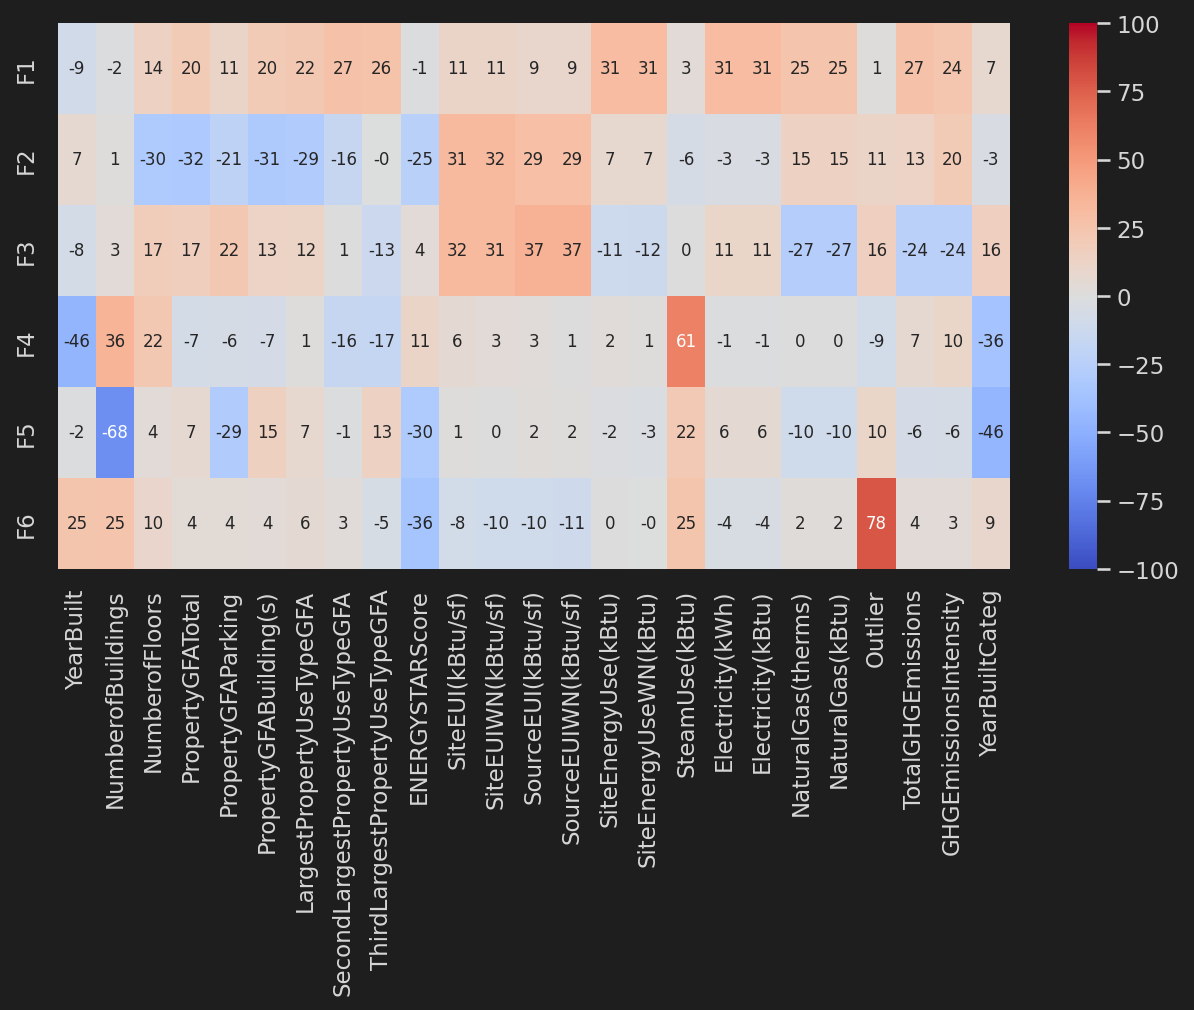

In [50]:
pcs = pd.DataFrame( pca.components_.transpose() )
pcs.index = features
columns = [f"F{i}" for i in x_list]
pcs.columns = columns

for i in range(6):
    key = f'F{i+1:}'
    display( pcs[[key]].sort_values( key, ascending=False ).T )

display( pcs.iloc[:,:6].round(2).T ) #.sort_values(by=indexes , ascending=False) )
fig, ax = plt.subplots(figsize=(26*cm, 12*cm))
sns.heatmap(pcs.iloc[:,:6].T*100, vmin=-100, vmax=100, annot=True, cmap="coolwarm", fmt="0.0f", annot_kws={"size": 8})
# fig.tight_layout( pad=0.2 )

In [51]:
def correlation_graph(pca,
                      ij_F,
                      features,
                      ax=None) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    ij_F : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    ax : axis sur lequel le graphique est tracé (default None -> est créé)
    """

    # Extrait x et y
    x,y=ij_F

    # Taille de l'image (en inches)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 9))
    else:
        fig = ax.get_figure()

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        ax.text(pca.components_[x, i] + 0.05*np.sign(pca.components_[x, i]),
                pca.components_[y, i] + 0.05*np.sign(pca.components_[y, i]),
                features[i])

    # Affichage des lignes horizontales et verticales
    ax.plot([-1, 1], [0, 0], color='grey', ls='--', zorder=0)
    ax.plot([0, 0], [-1, 1], color='grey', ls='--', zorder=0)

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    ax.set_ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    ax.set_title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(an), np.sin(an), zorder=0 )  # Add a unit circle for scale

    # Axes et display
    ax.axis('equal')
    plt.show(block=False)
    return fig, ax

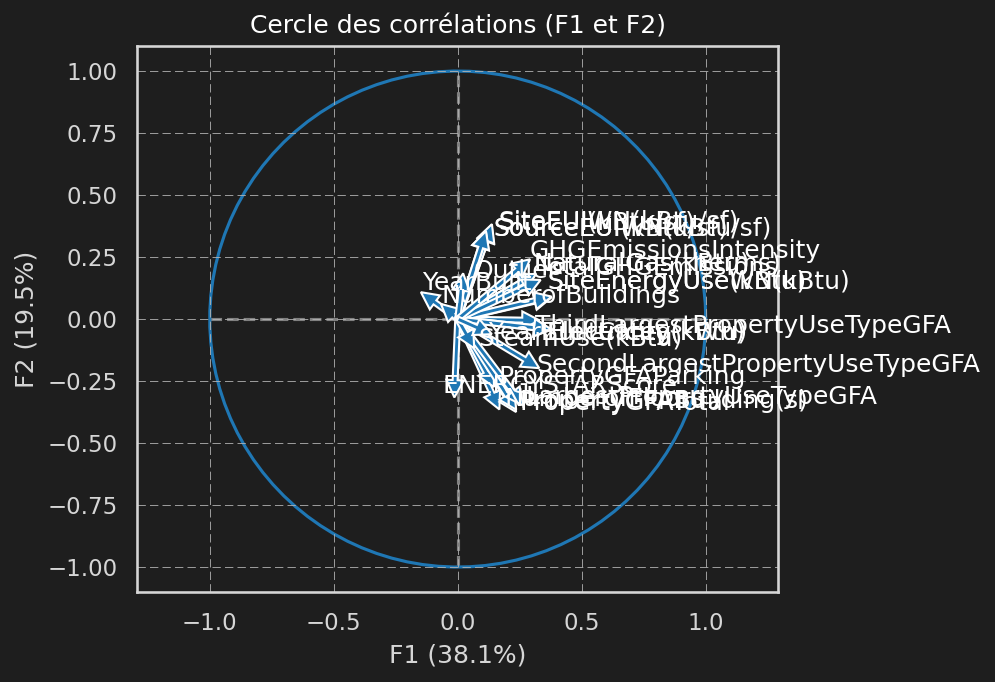

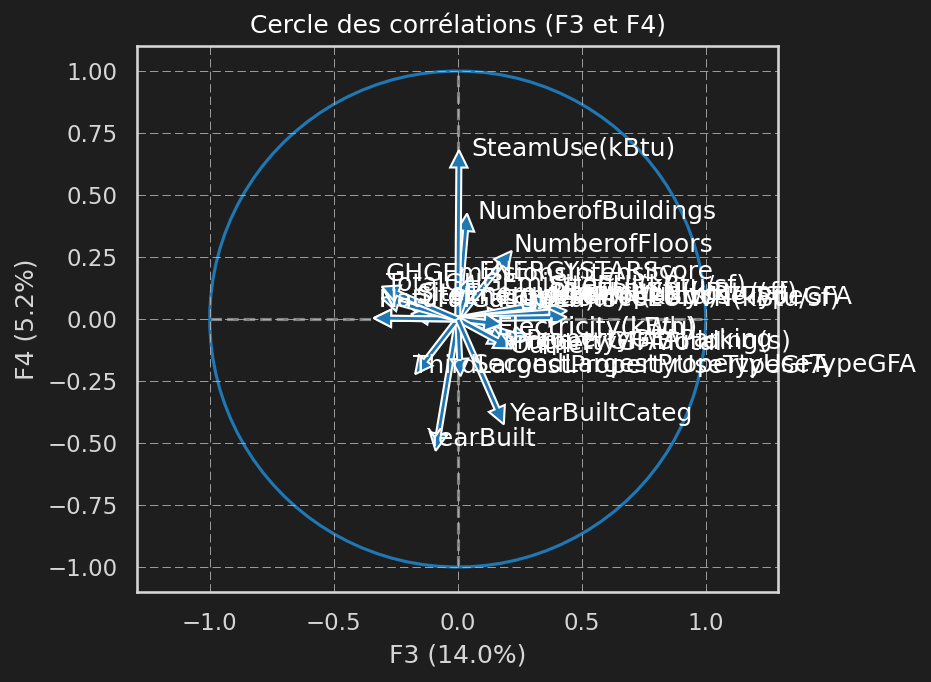

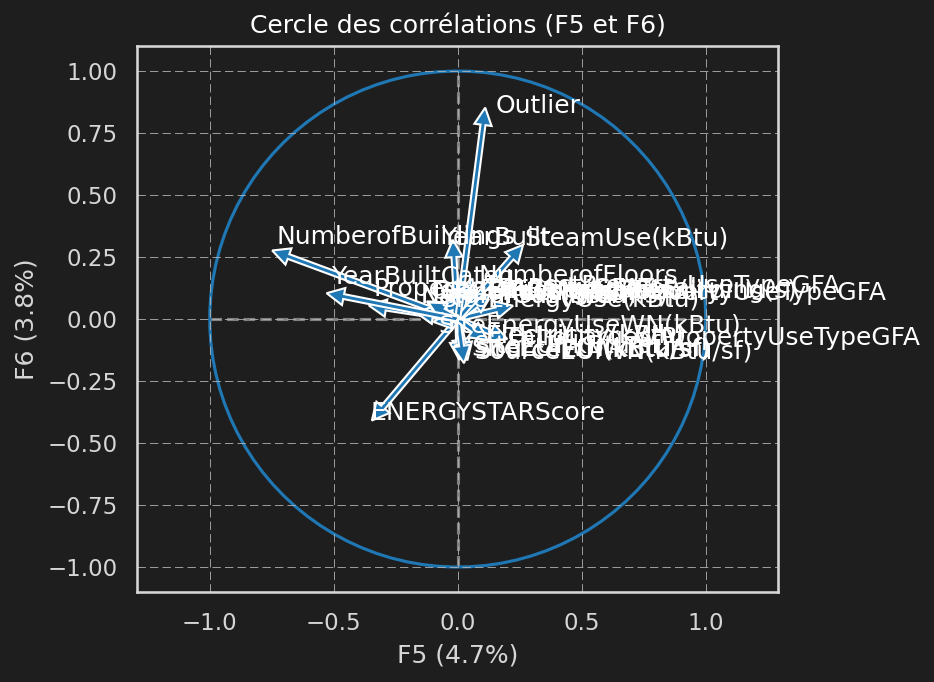

In [52]:
for i in range(3):
    fig, ax = plt.subplots( figsize=(14*cm, 12*cm))
    
    correlation_graph( pca, [i+i,i+i+1], features, ax=ax )
    fig.tight_layout( )

***
# 4. Target

## 4.1 Vérifications et gestion des données

Présence de valeurs incohérentes (0 != sum autres variables) pour `SiteEUIWN(kBtu/sf)`

On regarde les dates des relevés

In [53]:
display( df['DataYear'].value_counts() )

2016    1649
Name: DataYear, dtype: int64

Toutes les mesures ont été faites la même année

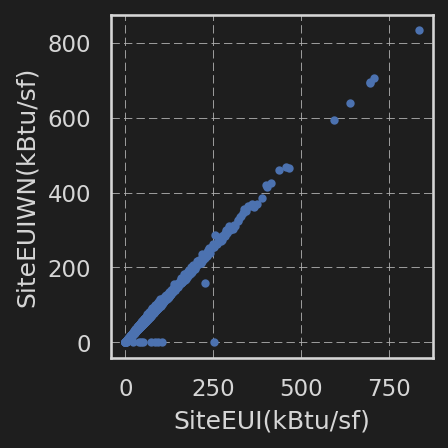

In [54]:
X, Y = 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)'
fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo', markersize=3 )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

- `SiteEUI(kBtu/sf)` est basée sur les factures
- `SourceEUI(kbtu/sf)` : "the annual energy used to operate the property, including losses from generation, transmission, & distribution."

estmated coefficient: 2.380


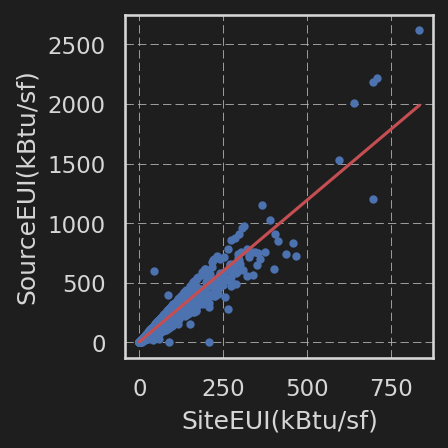

In [55]:
X, Y = 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo', markersize=3 )

x = np.array([0, df[X].max()]).reshape(2,1)
ax.plot( x, lr.predict(x), 'r' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Vérification de conversion kWh -> Btu : OK

estmated coefficient: 3.412, theoretical: 3.412142


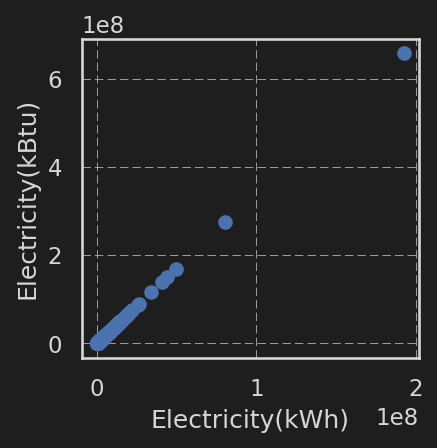

In [56]:
X, Y = 'Electricity(kWh)', 'Electricity(kBtu)'
coef = 3.412142 # in [Btu] / [Wh]

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}, theoretical: {coef:}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Vérification de conversion therms -> Btu : OK

estmated coefficient: 100.000, theoretical: 100.0


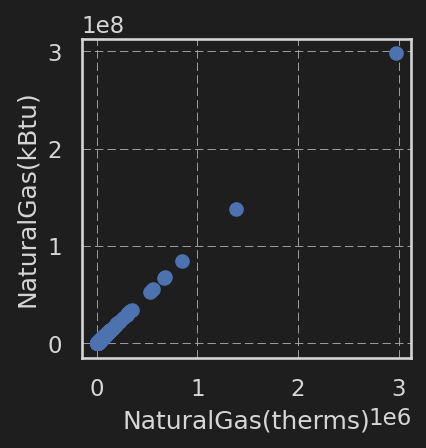

In [57]:
X, Y = 'NaturalGas(therms)', 'NaturalGas(kBtu)'
coef = 1e2 # in [kBtu]/[therms]

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}, theoretical: {coef:}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Vérification de la somme des ressources utilisées, <span style="color:red"> variations dues à ?? </span>

`SiteEnergyUse(kBtu)` :The annual amount of energy consumed by the property from all sources of energy.

count          mean           std       min         25%  \
SiteEnergyUse(kBtu)  1649.0  8.490866e+06  3.038810e+07       0.0  1242811.75   
sum ressources       1649.0  8.378698e+06  2.817698e+07 -115417.0  1257774.00   

                           50%        75%          max  
SiteEnergyUse(kBtu)  2564004.0  6960904.5  873923712.0  
sum ressources       2564004.0  6917279.0  742059629.0

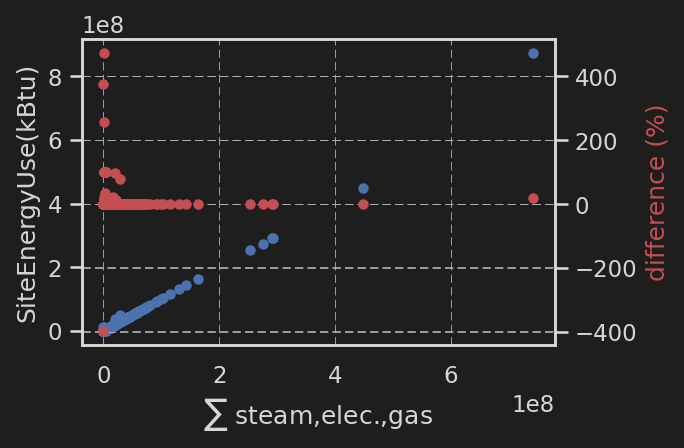

In [58]:
X, Y = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], 'SiteEnergyUse(kBtu)'

X_values = df[X].sum(1)
diff = X_values - df[Y]

display( pd.DataFrame( {Y:df[Y], 'sum ressources':X_values} ).describe().T )

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( X_values, df[Y], 'bo', markersize=4 )
ax.set_xlabel(r'$\sum$ steam,elec.,gas')
ax.set_ylabel(Y)

ax_twinx = ax.twinx()
ax_twinx.plot( X_values, np.abs(diff) / X_values * 100, 'ro', markersize=4 )
ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

On regarde à quoi correspondent les surfaces

Il y a clairement des incohérences entre les `LargestPropertyUseTypeGFA` et (`PropertyGFATotal`, `PropertyGFABuilding(s)`, `PropertyGFAParking`, `NumberofFloors`)

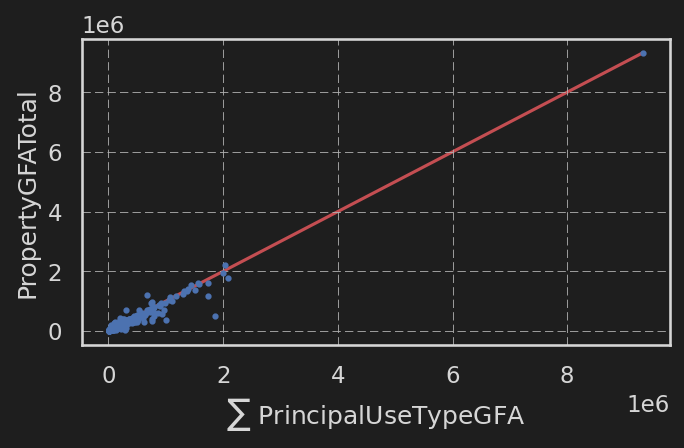

In [59]:
x = df[['LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA']].fillna(0.).sum(1)
# X = df['LargestPropertyUseTypeGFA']


Y1 = 'PropertyGFABuilding(s)'
Y2 = 'PropertyGFAParking'

Y = 'PropertyGFATotal'
y = df[Y]

# sr_loc = df['LargestPropertyUseType'] != 'parking'
# x = X.loc[sr_loc]
# y = y.loc[sr_loc]

# Y = 'GFA Building(s) + parking'
# y = df[Y1] + df[Y2]

# y = df['PropertyGFABuilding(s)'] * ( df['NumberofFloors'] +1 ) + df['PropertyGFAParking']
# Y = 'Surface à voir'

# diff = X - df[Y]
# display( pd.DataFrame( {Y:df[Y], 'sum surfaces':X_values} ).describe().T )

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( x, y, 'bo', markersize=2 )
ax.plot( [0, y.max()], [0, y.max()], 'r', zorder=0 )
# ax.plot( [0,y.max()], [0,y.max()], 'r', label='ideal match' )
# ax.legend()

ax.set_xlabel(r'$\sum$ PrincipalUseTypeGFA')
ax.set_ylabel(Y)

# ax_twinx = ax.twinx()
# ax_twinx.plot( X_values, np.abs(diff) / X_values * 100, 'ro', markersize=4 )
# ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'YearBuiltCateg']


count       mean        std  min        25%        50%  \
SiteEUI(kBtu/sf)  1649.0  72.463008  74.251074  0.0  33.700001  51.900002   
re-calculated     1649.0  68.269418  74.504581  0.0  31.149613  46.931689   

                        75%         max  
SiteEUI(kBtu/sf)  81.699997  834.400024  
re-calculated     75.153179  906.130957

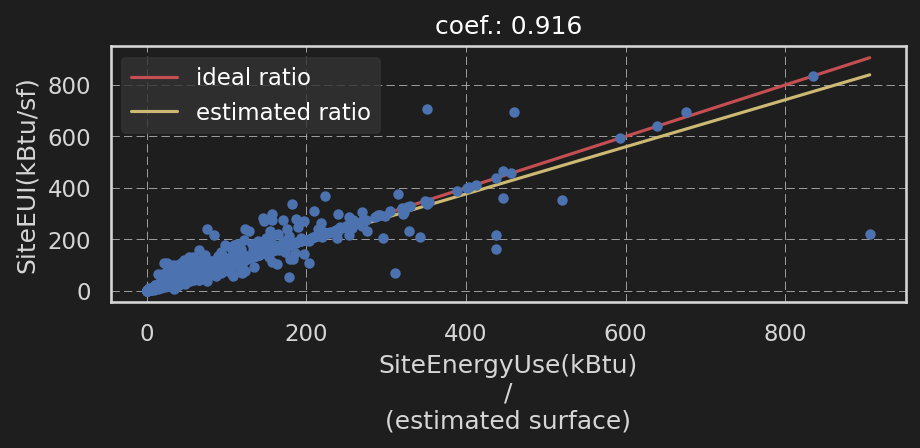

In [60]:
print( df.keys().tolist())
X, Y = 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)'

fig, ax = plt.subplots( figsize=(16*cm,8*cm))
X_values = df[X] / y
diff = X_values - df[Y]

lr = linear_model.LinearRegression()
lr.fit( X_values.values.reshape(-1,1), df[Y] )
# print( f'\nEstmated coefficient: {lr.coef_[0]:.3f}, ideal: {1:}' )

display( pd.DataFrame( {Y:df[Y], 're-calculated':X_values} ).describe().T )

ymax = df[Y].max()
xmax = X_values.max()
ax.set_title( f'coef.: {lr.coef_[0]:.3f}' )
ax.plot( [0,xmax], [0,xmax], 'r', label='ideal ratio' )
ax.plot( [0,xmax], lr.predict( np.array([0,xmax]).reshape(-1,1) ), 'y', label='estimated ratio' )
ax.plot( X_values, df[Y], 'bo', markersize=4 )
ax.set_xlabel( X + '\n/\n(estimated surface)')
ax.set_ylabel(Y)
ax.legend()

# ax_twinx = ax.twinx()
# ax_twinx.plot( X_values, np.abs(diff) / X_values * 100, 'ro', markersize=4 )
# ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

On prend la valeur "Weather Normalize".

number of elements target == 0 | isna: 21


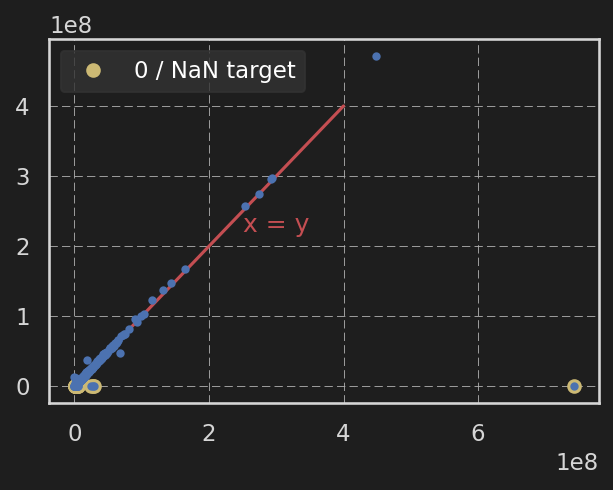

In [61]:
target = 'SiteEnergyUseWN(kBtu)'
sources = ['NaturalGas(kBtu)', 'Electricity(kBtu)',
            'SteamUse(kBtu)']

sr_0 = (df[target] == 0) | (df[target].isna())
print('number of elements target == 0 | isna:', (sr_0).sum())
# display( df.loc[sr_0,:])

y = df[target]
x = df[ sources ].fillna(0.).sum(1)

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( x.loc[sr_0], y.loc[sr_0], 'yo', label='0 / NaN target')
ax.plot( [0, 4e8], [0,4e8], 'r', zorder=1 )
ax.annotate('x = y', [2.5e8, 2.3e8], va='center', ha='left', color='r')

ax.plot( x, y , 'bo', markersize=3 )
ax.legend()

Calcul des valeurs manquantes

In [62]:
df[target] = x

sr_0 = (df[target] == 0) | (df[target].isna())
print('number of elements target == 0 | isna:', (sr_0).sum())
display( df.loc[sr_0,:])


number of elements target == 0 | isna: 1


OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
513            700      2016  nonresidential  supermarket / grocery store   

                  PropertyName                Address     City State  ZipCode  \
513  iuc- whole foods interbay  2001 15th avenue west  seattle    wa  98119.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
513                    7666201460                    7  magnolia / queen anne   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
513  47.63718 -122.37734       1948                1.0               1   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
513             57176                   0                   57176   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
513  personal services (health/beauty, dry cleaning...                  store   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
513                    39500.0                        store   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
513                          15000.0                    services   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
513                          5500.0                      NaN             31.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
513        208.800003          214.100006                 0.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
513                   0.0           12525174.0                    0.0   

     SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
513             0.0               0.0                0.0                 0.0   

     NaturalGas(kBtu)  DefaultData ComplianceStatus  Outlier  \
513               0.0        False        compliant        0   

     TotalGHGEmissions  GHGEmissionsIntensity  YearBuiltCateg  
513                0.0                    0.0               7

In [63]:
df.loc[sr_0,target] = df.loc[sr_0, 'SiteEnergyUse(kBtu)']

sr_0 = (df[target] == 0) | (df[target].isna())
print('number of elements target == 0 | isna:', (sr_0).sum())

number of elements target == 0 | isna: 0


Il y a un batiment (une "green structure") qui produit sa propre énergie et, à priori, plus que nécessaire 

In [64]:
sr_neg = df[target] < 0

display( df.loc[sr_neg,:] )

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3206          49784      2016  nonresidential  small- and mid-sized office   

        PropertyName              Address     City State  ZipCode  \
3206  bullitt center  1501 e. madison st.  seattle    wa  98122.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
3206                    7234600195                    3      central   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
3206  47.61432 -122.31257       2009                1.0               6   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
3206             52000                   0                   52000   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
3206                    office                 office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3206                    48159.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3206                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3206                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3206            100.0               7.1                 5.0   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3206                 2.0                  -2.1          342726.0938   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3206              -115417.0             0.0      -33826.80078   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3206          -115417.0                 0.0               0.0        False   

     ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  \
3206        compliant        0               -0.8                  -0.02   

      YearBuiltCateg  
3206               7

1.0


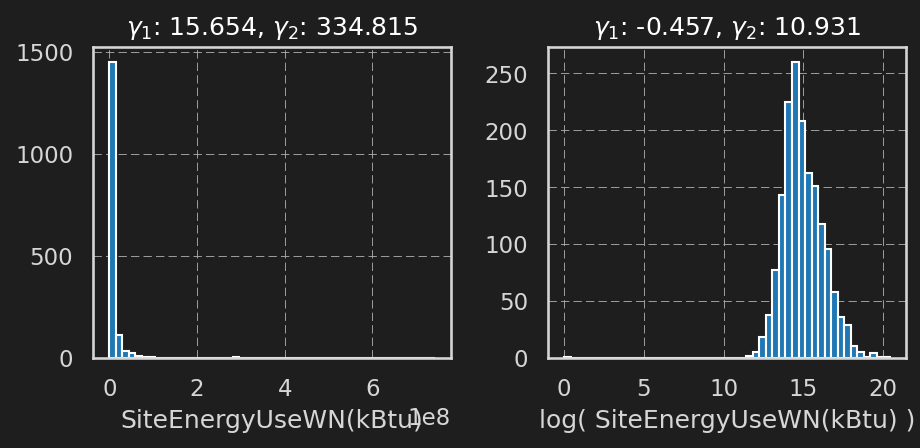

In [65]:

y = df[target].values

print( ( y + (1-y.min()) ).min() )
y_log = np.log( y + (1-y.min() ) )

fig, axs = plt.subplots( ncols=2, figsize=(16*cm,8*cm) )
n, bins, _ = axs[0].hist( y, bins=50 )
n, bins, _ = axs[1].hist( y_log, bins=50 )
axs[0].set_xlabel(target )
axs[1].set_xlabel( f'log( {target} )' )

axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_log), st.kurtosis(y_log) ) )

fig.tight_layout()

log_target_bins_center = (bins[:-1] + bins[1:]) * 0.5 

## 4.2 Scatter plots

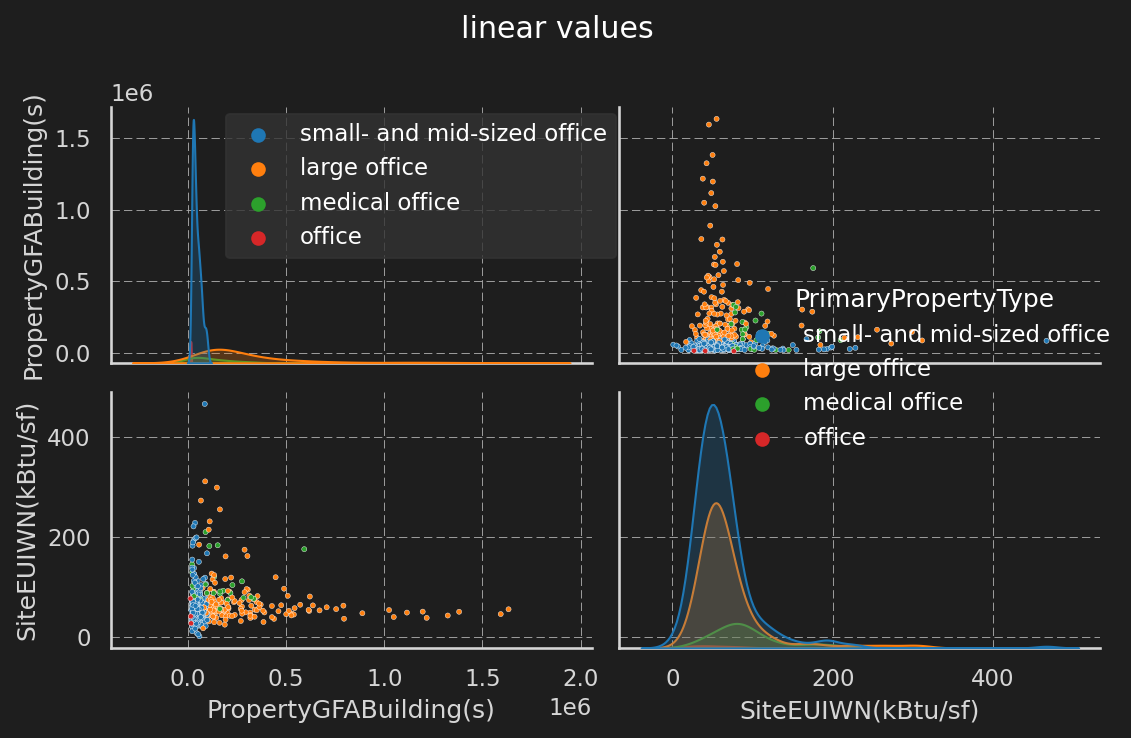

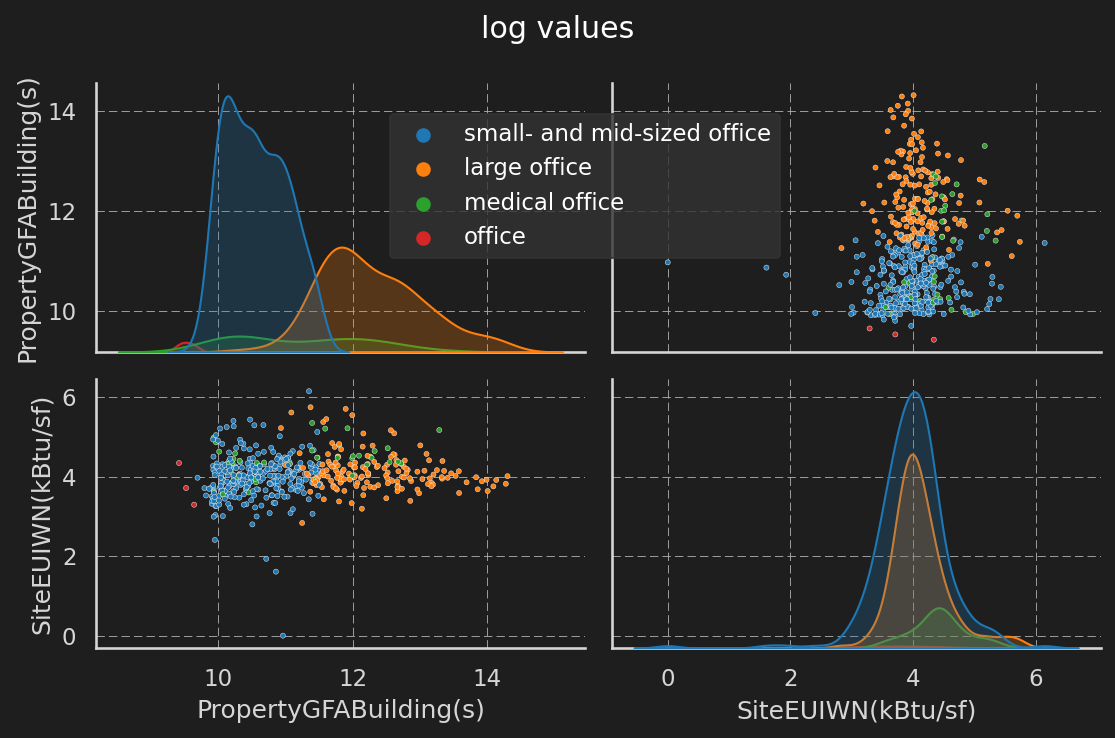

In [66]:

Xs = ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']
hues = ['PrimaryPropertyType', 'LargestPropertyUseType']

# df[target]

Y = 'SiteEUIWN(kBtu/sf)'

sr_loc = (df[Y] != 0)
for X in Xs:
    sr_loc = sr_loc & (df[X]!=0)
tmp = df.loc[sr_loc, Xs + hues + [Y, 'Outlier']]
# tmp = df[[X,target, 'Outlier', hue]]

if True:
    # tmp[ Xs[1] ] /= tmp[ Xs[0] ]
    # sr_loc = tmp[Xs[1]] > 0.7
    sr_loc = tmp[hues[0]].str.contains('office')
    tmp = tmp.loc[sr_loc,:]


for X,hue in zip( Xs, hues ):
    g = sns.pairplot( data=tmp, vars=[X,Y], hue=hue,
        plot_kws={'s':6} )
    
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=[0.2,0.65], ncol=1)

    g.fig.suptitle('linear values')
    g.fig.tight_layout()
    

    tmp[X] = np.log( tmp[X] )
    tmp[Y] = np.log( tmp[Y] )
    g = sns.pairplot( data=tmp, vars=[X,Y], hue=hue,
        plot_kws={'s':6} )
    # g.legend(bbox_to_anchor= (1.03, 1) )
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=[0.35,0.65], ncol=1)
    g.legend.remove()
    g.fig.suptitle('log values')
    g.fig.tight_layout()
    
    break


In [67]:
help( st.levene )

Help on function levene in module scipy.stats._morestats:

levene(*samples, center='median', proportiontocut=0.05)
    Perform Levene test for equal variances.
    
    The Levene test tests the null hypothesis that all input samples
    are from populations with equal variances.  Levene's test is an
    alternative to Bartlett's test `bartlett` in the case where
    there are significant deviations from normality.
    
    Parameters
    ----------
    sample1, sample2, ... : array_like
        The sample data, possibly with different lengths. Only one-dimensional
        samples are accepted.
    center : {'mean', 'median', 'trimmed'}, optional
        Which function of the data to use in the test.  The default
        is 'median'.
    proportiontocut : float, optional
        When `center` is 'trimmed', this gives the proportion of data points
        to cut from each end. (See `scipy.stats.trim_mean`.)
        Default is 0.05.
    
    Returns
    -------
    statistic : float
    

In [68]:
def ANOVA( df, hue, Y, transform=None ):
    groups = df[[Y,hue]].dropna().groupby(hue)[Y]
    index = pd.MultiIndex.from_tuples( [('shape','skew'), ('shape','kurtosis'),('shapiro','statistic'), ('shapiro','p-value')] )
    df_shape = pd.DataFrame( index = index)
    names = [name for name,yi in groups]
    for name, yi in groups:
        if not transform is None:
            yi = transform( yi )
        # print('\nname:', name)
        # print( st.skew(yi) )
        # print( st.kurtosis(yi) )
        # print( st.shapiro(yi) )
        # sr = pd.Series( [  ] ).astype(float)
        shapiro = st.shapiro(yi)
        df_shape[name] = [st.skew(yi), st.kurtosis(yi), shapiro.statistic, shapiro.pvalue]
    
    print('Shapiro null hypothesis: data has a normal distribution')
    display(df_shape.round(3))

    levene = pg.homoscedasticity( df.dropna(), dv=Y, group=hue )
    print( 'small p-value suggests that the populations do not have equal variances' )
    display( levene )

    # tpl = tuple( [df.query( f'{hue} == "{name}"')[Y].dropna() for name in names ] )
    # print( st.levene( *tpl ) )
    

    print('small p-value suggests that there is a statistically significant difference between the means of groups')
    display( pg.pairwise_tukey( dv=Y, between=hue, data=df.dropna() ) )

    # for i, (name,yi) in enumerate(groups):
    #     print('\n\n| {:} |\n\n'.format( '-'*20 ))
    #     if i+1 == len(names):
    #         break
    #     print(f'name: {name}')
    #     for j, (name_2,yi2) in enumerate(groups):
    #         if j <= i:
    #             continue
    #         print( f'\n{name} - {name_2}:' )
    #         stat, p = st.levene(yi, yi2)
    #         print( f'levene stat: {stat:.3f}, p-value: {p:.3f}' )
    #         print('std: {:.3f} - {:.3f}'.format( yi.std(), yi2.std() ) )
print('linear')
ANOVA( tmp, 'PrimaryPropertyType', 'SiteEUIWN(kBtu/sf)' )
# print('log')
# ANOVA( tmp, 'PrimaryPropertyType', 'SiteEUIWN(kBtu/sf)', lambda y:np.log( y + (1-y.min())) )

linear
Shapiro null hypothesis: data has a normal distribution


large office  medical office  office  \
shape   skew              1.176           0.079   0.239   
        kurtosis          2.554          -0.051  -1.500   
shapiro statistic         0.910           0.966   0.987   
        p-value           0.000           0.271   0.780   

                   small- and mid-sized office  
shape   skew                            -1.183  
        kurtosis                         9.486  
shapiro statistic                        0.901  
        p-value                          0.000

small p-value suggests that the populations do not have equal variances


W      pval  equal_var
levene  1.476883  0.219957       True

small p-value suggests that there is a statistically significant difference between the means of groups


A                            B   mean(A)   mean(B)      diff  \
0    large office               medical office  4.117974  4.420021 -0.302048   
1    large office                       office  4.117974  3.781053  0.336921   
2    large office  small- and mid-sized office  4.117974  3.979231  0.138743   
3  medical office                       office  4.420021  3.781053  0.638969   
4  medical office  small- and mid-sized office  4.420021  3.979231  0.440791   
5          office  small- and mid-sized office  3.781053  3.979231 -0.198178   

         se         T   p-tukey    hedges  
0  0.092866 -3.252517  0.006683 -0.667575  
1  0.304481  1.106543  0.685674  0.735009  
2  0.050590  2.742510  0.031966  0.261477  
3  0.313207  2.040084  0.174758  1.440963  
4  0.089159  4.943860  0.000006  0.793626  
5  0.303371 -0.653253  0.914391 -0.347876

Les "office" semblent être des "small" offices

In [69]:
mask = "PrimaryPropertyType"
df.loc[ df[mask] == 'office', mask] = 'small- and mid-sized office'

***
# 5. Features des modèles

In [70]:
features = [ feature for feature in df.columns if not feature in vars_to_delete ]

print( features )

['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'YearBuiltCateg']


In [71]:
features_1 = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
    'NumberofBuildings', 'NumberofFloors', 'YearBuiltCateg',
    'YearBuilt', 'PropertyGFABuilding(s)']
features_2 = ['YearsENERGYSTARCertified', 'ENERGYSTARScore', target]  # TODO: 'TotalGHGEmissions', 'GHGEmissionsIntensity'
features_3 = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
features_4 = ['DefaultData', 'ComplianceStatus', 'Outlier']

## 5.1 OneHotEncoding

In [72]:
value_counts = df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int)

PropertyUseTypes = value_counts.index
PropertyUseTypes = PropertyUseTypes.drop( 'parking' )
print(PropertyUseTypes)

X_propotion_PropertyUseTypeGFA = np.zeros( (len(df), len(PropertyUseTypes)) )
X_ParkingGFA = np.zeros( len(df) )
for i, index in enumerate(df.index):
    for suffix in ['','Second','Third']:
        usetype = df.at[index, suffix + 'LargestPropertyUseType']
        if isinstance( usetype, float ): # test if isnan
            break
        if usetype == 'parking':
            X_ParkingGFA[i] += df.at[ index, 'LargestPropertyUseTypeGFA']
            continue
        j = PropertyUseTypes.get_loc( usetype )
        X_propotion_PropertyUseTypeGFA[i,j] += df.at[index, 'LargestPropertyUseTypeGFA']

X_propotion_PropertyUseTypeGFA /= X_propotion_PropertyUseTypeGFA.sum(1).reshape(-1,1)

Index(['data center', 'distribution center', 'education',
       'entertainment/public assembly', 'lifestyle center',
       'manufacturing/industrial plant', 'medical', 'medical office',
       'non-refrigerated warehouse', 'office', 'other',
       'other - entertainment/public assembly', 'refrigerated warehouse',
       'residential - hotel', 'restaurant', 'science', 'self-storage facility',
       'services', 'store', 'utility', 'worship facility'],
      dtype='object')


In [73]:
df.loc[ df[features_4].sum(1)==0 ]

/tmp/ipykernel_6246/3926721074.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.loc[ df[features_4].sum(1)==0 ]


OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      nonresidential               hotel   
1                 2      2016      nonresidential               hotel   
2                 3      2016      nonresidential               hotel   
3                 5      2016      nonresidential               hotel   
4                 8      2016      nonresidential               hotel   
...             ...       ...                 ...                 ...   
3370          50221      2016  nonresidential cos               other   
3372          50223      2016  nonresidential cos               other   
3373          50224      2016  nonresidential cos               other   
3374          50225      2016  nonresidential cos  mixed use property   
3375          50226      2016  nonresidential cos  mixed use property   

                             PropertyName           Address     City State  \
0                    mayflower park hotel     405 olive way  seattle    wa   
1                         paramount hotel   724 pine street  seattle    wa   
2                 5673-the westin seattle   1900 5th avenue  seattle    wa   
3                               hotel max    620 stewart st  seattle    wa   
4             warwick seattle hotel (id8)     401 lenora st  seattle    wa   
...                                   ...               ...      ...   ...   
3370          high point community center  6920 34th ave sw  seattle    wa   
3372  international district/chinatown cc     719 8th ave s  seattle    wa   
3373                      queen anne pool    1920 1st ave w  seattle    wa   
3374          south park community center    8319 8th ave s  seattle    wa   
3375          van asselt community center  2820 s myrtle st  seattle    wa   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
0     98101.0                    0659000030                    7   
1     98101.0                    0659000220                    7   
2     98101.0                    0659000475                    7   
3     98101.0                    0659000640                    7   
4     98121.0                    0659000970                    7   
...       ...                           ...                  ...   
3370  98126.0                    2524039059                    1   
3372  98134.0                    3558300000                    2   
3373  98119.0                    1794501150                    7   
3374  98108.0                    7883603155                    1   
3375  98108.0                    7857002030                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
0                  downtown  47.61220 -122.33799       1900   
1                  downtown  47.61317 -122.33393       1900   
2                  downtown  47.61393 -122.33810       1900   
3                  downtown  47.61412 -122.33664       1900   
4                  downtown  47.61375 -122.34047       1900   
...                     ...       ...        ...        ...   
3370               delridge  47.54067 -122.37441       2015   
3372               downtown  47.59625 -122.32283       2015   
3373  magnolia / queen anne  47.63644 -122.35784       2015   
3374       greater duwamish  47.52832 -122.32431       2015   
3375       greater duwamish  47.53939 -122.29536       2015   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3370                1.0               1            

In [74]:
X_propotion_energy = df[ features_3 ].values
X_propotion_energy[X_propotion_energy.sum(1)==0] = 1.  # to avoid problem with 0.
X_propotion_energy /= X_propotion_energy.sum(1).reshape(-1,1)

# 6. Sauvegarde

In [75]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df[features_1+features_2+features_3+features_4].to_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)

filename = 'other_data.pkl'
with open( path + filename , 'wb' ) as file:
    pickle.dump( (features_1,features_2,
    features_3,features_4,
    PropertyUseTypes,
    X_propotion_PropertyUseTypeGFA,
    X_ParkingGFA,
    X_propotion_energy),
    file )

***
# dummy

In [ ]:
df_num = pd.DataFrame()
features = ['Longitude', 'Latitude', 'YearBuilt',
        'NumberofBuildings', 'NumberofFloors',
        'PropertyGFATotal', 'PropertyGFAParking']
df_num[features] = df[features].values

df_num.isna().sum()

In [ ]:
arr_0 = df['LargestPropertyUseType'].unique()
arr_1 = df['SecondLargestPropertyUseType'].unique()
arr_2 = df['ThirdLargestPropertyUseType'].unique()

arr = np.concatenate( (arr_0, arr_1, arr_2 ))
print(arr.size)
PropertyUseTypes = [val for i, val in enumerate(arr) if (not val in arr[:i]) & ~isinstance(val, float)]
print( len(PropertyUseTypes) )
X_PropertyUseTypeGFA = np.zeros( (len(df), len(PropertyUseTypes)) )
for i, index in enumerate(df.index):
    for suffix in ['','Second','Third']:
        usetype = df.at[index, suffix + 'LargestPropertyUseType']
        if isinstance( usetype, float): # test if isnan
            break
        j = PropertyUseTypes.index( usetype )
        X_PropertyUseTypeGFA[i,j] += df.at[index, 'LargestPropertyUseTypeGFA']

features += ['GFA ' + usetype for usetype in PropertyUseTypes]

In [ ]:
X = np.hstack( (df_num.values,X_PropertyUseTypeGFA) )
y = df[target]
sr_loc = ~(y.isna()) & (y != 0)

X = X[sr_loc.values]
y = np.log( y.values[sr_loc.values] )

def bin_to_class( val, bins ):
    for i, bin in enumerate(bins):
        if val < bin:
            return i
    return len(bins) 
y_classes = np.array([ bin_to_class( val, log_target_bins_center ) for val in y ])

indexes = sr_loc[sr_loc].index


## PCA

In [ ]:
scaler_pca = preprocessing.StandardScaler()
X_scaled = scaler_pca.fit_transform(X) # fit and transform
idx = ["mean", "std"]
display( pd.DataFrame(X_scaled).describe().round(2).loc[idx, :] )

In [ ]:
from sklearn.decomposition import PCA
n_components = X_scaled.shape[1]
pca = PCA(n_components=n_components)

# entrainement
pca.fit(X_scaled)

In [ ]:
x_list = range(1, n_components+1)
scree = (pca.explained_variance_ratio_*100)
print('scree:', scree.round(2))
print('sum scree:', scree.sum().round(2))
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.bar( x_list, scree )
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("inertie (%)")
ax.set_title('Éboulis des valeurs propres')

ax = ax.twinx()
ax.set_ylabel("inertie (%)")

ax.plot( x_list, scree.cumsum(), c='r', marker='o', label='intertie cumulée')
ax.legend()

fig.tight_layout(pad=0.2)
# tools.savefig( fig, 'Figures/PCA/ebouli.pdf')


In [ ]:
pcs = pd.DataFrame( pca.components_.transpose() )
pcs.index = features
columns = [f"F{i}" for i in x_list]
pcs.columns = columns

for i in range(20):
    key = f'F{i+1:}'
    display( pcs[[key]].sort_values( key, ascending=False ).T )

display( pcs.round(2).T ) #.sort_values(by=indexes , ascending=False) )
fig, ax = plt.subplots(figsize=(18*cm, 8*cm))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
fig.tight_layout( pad=0.2 )

In [ ]:
def correlation_graph(pca,
                      ij_F,
                      features,
                      ax=None) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    ij_F : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    ax : axis sur lequel le graphique est tracé (default None -> est créé)
    """

    # Extrait x et y
    x,y=ij_F

    # Taille de l'image (en inches)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 9))
    else:
        fig = ax.get_figure()

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        ax.text(pca.components_[x, i] + 0.05*np.sign(pca.components_[x, i]),
                pca.components_[y, i] + 0.05*np.sign(pca.components_[y, i]),
                features[i])

    # Affichage des lignes horizontales et verticales
    ax.plot([-1, 1], [0, 0], color='grey', ls='--', zorder=0)
    ax.plot([0, 0], [-1, 1], color='grey', ls='--', zorder=0)

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    ax.set_ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    ax.set_title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(an), np.sin(an), zorder=0 )  # Add a unit circle for scale

    # Axes et display
    ax.axis('equal')
    plt.show(block=False)
    return fig, ax

In [ ]:
for i in range(3):
    fig, ax = plt.subplots( figsize=(14*cm, 12*cm))
    
    correlation_graph( pca, [i+i,i+i+1], features, ax=ax )
    fig.tight_layout( )

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

_, _, i_train, i_test = model_selection.train_test_split( range(len(y)) , 
                                    range(len(y)), train_size=0.8)

X_train = X[i_train, :]
X_test = X[i_test, :]
y_train = y_classes[i_train]
y_test = y_classes[i_test]

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# help( RandomForestClassifier )
rfc = RandomForestClassifier( n_estimators=100, n_jobs=-1, oob_score=True )
rfc.fit( X_train, y_train )

pred = rfc.predict(X_test)
print("accuracy: {:.2f}%".format(100* metrics.accuracy_score(y_test, pred)) )
print('score: {:.2f}'.format( 100*rfc.score( X_test, y_test) ))

argsort = y_test.argsort()
fig, ax = plt.subplots()
ax.plot( pred[argsort], 'o' )
ax.plot( y_test[argsort], 'r' )

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# X_train = X[i_train, :]
# X_test = X[i_test, :]
y_train = y[i_train]
y_test = y[i_test]


rfr = RandomForestRegressor( n_estimators=100, n_jobs=-1, oob_score=True )
rfr.fit( X_train, y_train )
print("score: {:.2f}".format(100* rfr.score(X_test, y_test)) )
y_pred = rfr.predict( X_test )
# help( rfr.score )

argsort = y_test.argsort()
fig, axs = plt.subplots(nrows=2)
axs[0].plot( y_pred[argsort], 'o' )
axs[0].plot( y_test[argsort], 'r' )

y_train = np.exp( y_train )
y_test = np.exp( y_test )

rfr = RandomForestRegressor( n_estimators=100, n_jobs=-1, oob_score=True )
rfr.fit( X_train, y_train )
print("score: {:.2f}".format(100* rfr.score(X_test, y_test)) )
y_pred = rfr.predict( X_test )

axs[1].semilogy( y_pred[argsort], 'o' )
axs[1].plot( y_test[argsort], 'r' )

***
# Random Forest

In [ ]:
vars_X = ['BuildingType', 'PrimaryPropertyType',
        'ZipCode', 'TaxParcelIdentificationNumber',
        'CouncilDistrictCode', 'Neighborhood',
        'Latitude', 'Longitude',
        'YearBuilt', 'NumberofBuildings',
        'NumberofFloors', 'PropertyGFATotal',
        'PropertyGFAParking', 'PropertyGFABuilding(s)',
        'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'
        ]


X = df[vars_X].copy()
keys = [ 'LargestPropertyUseType', 'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType' ]

X[ keys ] = X[keys].fillna( 'None' )

keys = [ 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA' ]
X[ keys ] = X[keys].fillna( 0. )

display( X.isna().sum())
y = df[target].copy()

def bin_to_class( val, bins ):
    for i, bin in enumerate(bins):
        if val < bin:
            return i
    return len(bins) 
y_classes = pd.Series( [ bin_to_class( val, log_target_bins_center ) for val in y ] , index=y.index )



In [ ]:
from sklearn.ensemble import RandomForestClassifier

_, _, index_train, index_test = model_selection.train_test_split( range(len(df)) , 
                                    X.index, train_size=0.8)

X_train = X.loc[index_train, :]
X_test = X.loc[index_test, :]
y_train = y_classes.loc[index_train]
y_test = y_classes.loc[index_test]

help( RandomForestClassifier )
rfc = RandomForestClassifier( n_estimators=100, n_jobs=-1, oob_score=True )
rfc.fit( X_train, y_train )

In [ ]:
from sklearn.ensemble import RandomForestRegressor

_, _, index_train, index_test = model_selection.train_test_split( range(len(df)) , 
                                    X.index, train_size=0.8)

X_train = X.loc[index_train, :]
X_test = X.loc[index_test, :]
y_train = y.loc[index_train]
y_test = y.loc[index_test]

rfr = RandomForestRegressor( n_estimators=100, n_jobs=-1, oob_score=True )
rfr.fit( X_train, y_train )

# Quels types d'utilisation ?
- il est probablement préférable de ne garder que le `PrimaryPropertyType`
- il y a une `incohérence` dans le tri `large` | `small- or mid-sized` office : les histrogrammes se recoupent
- <span style="color:red"> residence hall/domitory ? </span>
- <span style="color:red"> LargestPropertyUseType : other - lodging/residential ? </span>
- <span style="color:red"> Faut-il faire quelques groupes ? Offiche + others ? </span>

In [ ]:
vars = ['PrimaryPropertyType',
        'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']

for var in vars:
    value_counts = df[var].value_counts()
    display( value_counts )
    fig, ax = plt.subplots()
    value_counts.plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( var )
    ax.set_ylabel('')
    fig.tight_layout(pad=0.2)


fig, ax = plt.subplots()

print('small- and mid-sized office')
sr_loc = df[vars[0]].str.contains('mid-sized office')
display( df.loc[sr_loc, ['LargestPropertyUseTypeGFA'] ].describe() )

values_small_med = np.log( df.loc[sr_loc, 'LargestPropertyUseTypeGFA' ].values )


var_surf = 'LargestPropertyUseTypeGFA'

print('large office')
sr_loc = df[vars[0]].str.contains('large office')
display( df.loc[sr_loc, [var_surf] ].describe() )

values_large = np.log( df.loc[sr_loc, var_surf] )

ax.hist( [values_small_med, values_large],
        bins=50, label=['small- and mid-sized', 'large'] )

ax.plot([],[], 'r', label='size not referenced')

ax.legend()
ax.set_title('histogram of the surface used as office')

sr_loc = df[vars[0]] == 'office'
for value in df.loc[sr_loc, var_surf]:
    ax.plot( [np.log(value),]*2, [0,10] , 'r')

## Observation office size - targets

In [ ]:
targets = ['TotalGHGEmissions']